In [38]:
#import
import tqdm
import math
import wandb
import torch
import pylab
import torchmetrics

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import lightning.pytorch as pl
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torchmetrics import MeanAbsoluteError
from sklearn.metrics import mean_squared_error
from lightning.pytorch.loggers import CSVLogger
from torch.utils.data import Dataset, DataLoader, random_split
from lightning.pytorch.loggers import WandbLogger
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint

In [2]:
#make screen wide
from IPython.core.display import display, HTML
from IPython import get_ipython as get_ipython
display(HTML(
    '<style>'
        '#notebook { padding-top:0px !important;margin-left:-30px !important; } ' 
        '.container { width:100% !important; } '
        '.end_space { min-height:0px !important; } '
    '</style>'
))

# Reading model and data

In [5]:
#params
logger_path = './wandb_local_logs'
data_path = '../data/clasdb_pi_plus_n.txt'

project_name = "MSU_interpol"

scale_data = False
test_size = 0.1
batch_size = 32
net_architecture = [5, 60, 80, 100, 120, 140, 240, 340, 440, 640, 2000, 1040, 640, 340, 240, 140, 100, 80, 60, 20, 1]
lr = 0.00001
activation_function = nn.ReLU()
loss_func = RMSELoss()
optim_func = torch.optim.Adam
max_epochs = 2000
min_delta = 0.0001
patience = 20

hyperparams_dict = {
    'scale_data': scale_data,
    'test_size': test_size,
    'batch_size': batch_size,
    'lr': lr,
    'net_architecture': net_architecture,
    'activation_function': activation_function,
    'loss_func': loss_func,
    'optim_func': optim_func,
    'max_epochs': max_epochs,
    'min_delta': min_delta,
    'patience': patience
}

In [4]:
class InterpolDataSet(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        self.len = len(labels)

    def __getitem__(self, index):
        feature = self.features[index]
        label = self.labels[index]
        return feature, label

    def __len__(self):
        return self.len

class InterpolDataModule(pl.LightningDataModule):
    def __init__(self):
        super().__init__()
        self.df = None
    
    def setup(self, stage):
        # data reading and preprocessing
        df = pd.read_csv(data_path, delimiter='\t', header=None)
        df.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']

        df.loc[8314:65671, 'Ebeam'] = 5.754 # peculiarity of this dataset.
        df['phi'] = df.phi.apply(lambda x: math.radians(x))
        df = df.drop('id', axis=1)
        df = df.iloc[df[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']].drop_duplicates().index]
        self.df = df
        
        #train test split
        feature_data = df[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']]
        label_data = df['dsigma_dOmega']
        
        if scale_data:
            scaler_feature = StandardScaler()
            scaler_target = StandardScaler()
            feature_data = scaler_feature.fit_transform(feature_data)
            label_data = scaler_target.fit_transform(label_data.values.reshape(-1,1))
        else:
            pass
        
        train_feature_data, val_feature_data, train_label_data, val_label_data = train_test_split(feature_data, label_data, 
                                                                                                  test_size=test_size, random_state=1438)
        
        
        self.train_dataset = InterpolDataSet(torch.tensor(train_feature_data.values, dtype=torch.float32), 
                                             torch.tensor(train_label_data.values, dtype=torch.float32))
        
        self.val_dataset = InterpolDataSet(torch.tensor(val_feature_data.values, dtype=torch.float32), 
                                            torch.tensor(val_label_data.values, dtype=torch.float32))
    def train_dataloader(self):
        return DataLoader(dataset = self.train_dataset, batch_size = batch_size, shuffle = False, num_workers=0)

    def val_dataloader(self):
        return DataLoader(dataset = self.val_dataset, batch_size = batch_size, shuffle = False, num_workers=0)
    
class RMSELoss(torch.nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()

    def forward(self,x,y):
        criterion = nn.MSELoss()
        loss = torch.sqrt(criterion(x, y))
        return loss

In [6]:
class InterpolRegressor(pl.LightningModule):
    def __init__(self, hyperparams):
        super(InterpolRegressor, self).__init__()
        
        self.hyperparams = hyperparams
        self.save_hyperparameters(self.hyperparams)
        
        self.mae = MeanAbsoluteError()
        self.loss_func = self.hyperparams.get('loss_func')
        
        self.optim = self.hyperparams.get('optim_func')
        
        self.net_architecture = self.hyperparams.get('net_architecture')
        self.activation_function = self.hyperparams.get('activation_function')
        
        self.net = nn.Sequential()              
        for i in range(1,len(self.net_architecture)):
            self.net.append(nn.Linear(self.net_architecture[i-1], self.net_architecture[i]))
            if i!=len(self.net_architecture)-1:
                self.net.append(self.activation_function)
            else:
                pass

    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        
        loss = self.loss_func
        self.train_loss = loss(y_hat.reshape(-1), y)
        
        self.mae_train = self.mae(y_hat.reshape(-1), y)
        
        self.log('train_loss', self.train_loss, batch_size=self.hyperparams['batch_size'], 
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('train_mae', self.mae_train, batch_size=self.hyperparams['batch_size'], 
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        return self.train_loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        
        loss = self.loss_func
        self.val_loss = loss(y_hat.reshape(-1), y)
        
        self.mae_val = self.mae(y_hat.reshape(-1), y)
        
        self.log('val_loss', self.val_loss, batch_size=self.hyperparams['batch_size'], 
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('val_mae', self.mae_val, batch_size=self.hyperparams['batch_size'], 
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        return self.val_loss

    #     def on_train_epoch_end(self):
    #         self.log('train_loss', self.train_loss, on_step=False, on_epoch=True, prog_bar=False)

    #     def on_validation_epoch_end(self):
    #         self.log('step', self.trainer.current_epoch)
    #         self.log('val_loss', self.val_loss, on_step=False, on_epoch=True, prog_bar=False)
    
    def configure_optimizers(self):
        optimizer = self.optim(self.parameters(), lr=self.hyperparams.get('lr'))
        return optimizer

In [7]:
data = InterpolDataModule()
data.setup('test')
df = data.df
df_all = df[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']]
df_target = df[['dsigma_dOmega']]

model = InterpolRegressor.load_from_checkpoint(f'./wandb_local_logs/MSU_interpol/glad-mountain-6/checkpoints/exp_name=0val_loss=0.33058-epoch=319.ckpt', hyperparams=hyperparams_dict)
model.eval()
type(model)

/Users/andrey.golda/.pyenv/versions/3.9.0/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/Users/andrey.golda/.pyenv/versions/3.9.0/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.


__main__.InterpolRegressor

In [8]:
preds = model.forward(torch.tensor(df_all.to_numpy(),dtype=torch.float32)).detach()
lables = torch.tensor(df_target.to_numpy(),dtype=torch.float32).reshape(-1,1)
loss = RMSELoss()
loss.forward(preds, lables)

tensor(0.4112)

# Checks

In [36]:
def interpol_check(df, number):
    example = df.iloc[number][['Ebeam', 'W', 'Q2', 'cos_theta']]
    
    df_example_set = df[(df.Ebeam == example['Ebeam'])&
                       (df.W == example['W'])&
                       (df.Q2 == example['Q2'])&
                       (df.cos_theta == example['cos_theta'])].sort_values('phi')
    
    df_example_set_for_prediction = pd.DataFrame({'Ebeam' : [example['Ebeam'] for _ in np.arange(0, 2*np.pi, 0.01)], 
                                                  'W' : [example['W'] for _ in np.arange(0, 2*np.pi, 0.01)], 
                                                  'Q2' : [example['Q2'] for _ in np.arange(0, 2*np.pi, 0.01)], 
                                                  'cos_theta' : [example['cos_theta'] for _ in np.arange(0, 2*np.pi, 0.01)],
                                                  'phi' : [phi for phi in np.arange(0, 2*np.pi, 0.01)]})

#     return df_example_set
    with torch.no_grad():
        dsigma_dOmega_predicted = model.forward(torch.tensor(df_example_set_for_prediction.to_numpy(),dtype=torch.float32)).detach()
     
    def func_cos(x, a, b, c): 
        return a + b*np.cos(2*x) + c*np.cos(x) 

    #input data 
    xdata = df_example_set.phi
    ydata = df_example_set.dsigma_dOmega 

    #fitting the data 
    popt, pcov = curve_fit(func_cos, xdata, ydata) 

    a, b, c = popt[0], popt[1], popt[2]
    #print the fitted parameters 
    print("a = %s , b = %s, c = %s" % (a, b, c))
    phi_theory = [i for i in np.arange(0, 2*np.pi, 0.01)]
    dsigma_dOmega_theory = [func_cos(x, a, b, c) for x in phi_theory]
    
    plt.figure(figsize=(22, 6), dpi=80)
    plt.plot(phi_theory, 
             dsigma_dOmega_theory, 
             label=f'fitted a + b*cos(2*x) + c*cos(x) function')
    plt.plot(df_example_set_for_prediction.phi, 
             dsigma_dOmega_predicted, 
             color='green', label=f'predicted')
    plt.scatter(x=df_example_set.phi, 
                y=df_example_set.dsigma_dOmega, 
                color='red', marker='*', label=f"real_data with params Ebeam: {example['Ebeam']}, W: {example['W']}, Q2: {example['Q2']}, cos_theta: {example['cos_theta']}")
    
    plt.xlabel("phi: rad")
    plt.ylabel("dsigma_dOmega: barn")
    
    plt.legend()
    plt.show()

In [65]:
interpol_check(df, randint(0, len(df)))

In [62]:
def integral_cross_section_W_Q2():
    rand_n = randint(0, len(df))
    grid_step_phi = 0.001
    grid_step_q2 = 0.5

    example = df.iloc[rand_n]
    df_example_set = df[(df.Ebeam == example['Ebeam'])&
                       (df.cos_theta == example['cos_theta'])].sort_values('phi')

    phi_grid = np.arange(0, 2*np.pi, grid_step_phi)
    W_grid = np.sort(df_example_set.W.unique())
    Q2_grid = np.arange(df_example_set.Q2.min(), df_example_set.Q2.max(), grid_step_q2)



    final_list = []

    for j in range(len(Q2_grid)):
        for i in range(len(W_grid)):
            one_set = pd.DataFrame({'Ebeam' : [example['Ebeam'] for _ in range(len(phi_grid))],
                                     'W' :  [W_grid[i] for _ in range(len(phi_grid))],
                                     'Q2' : [Q2_grid[j] for _ in range(len(phi_grid))],
                                     'cos_theta' : [example['cos_theta'] for _ in range(len(phi_grid))],
                                     'phi' : phi_grid})
            
            
            one_predictions_set = model.forward(torch.tensor(one_set.to_numpy(),dtype=torch.float32)).detach()

            final_list.append({'Ebeam' : example['Ebeam'],
                                'W' :  W_grid[i],
                                'Q2' : Q2_grid[j],
                                'cos_theta' : example['cos_theta'],
                                'phi' : 'all_phi',
                                'dsigma_dOmega' : np.trapz(one_predictions_set.flatten(), dx=grid_step_phi)})

        cross_sections_int = [element['dsigma_dOmega'] for element in final_list]


    df_final_list = pd.DataFrame(final_list)

    plt.figure(figsize=(22, 6), dpi=80)
    for j in range(len(Q2_grid)):
        plt.scatter(x=W_grid, 
                    y=df_final_list[df_final_list.Q2 == Q2_grid[j]]['dsigma_dOmega'], 
                    marker='*', label=f"Predicted integral cross_section. Fixed params: Ebeam {example['Ebeam']}, Q2: {np.round(Q2_grid[j],2)}, cos_theta: {example['cos_theta']}")

    plt.xlabel("W: GeV")
    plt.ylabel("dsigma_dOmega: barn")

    plt.legend()
    plt.show()

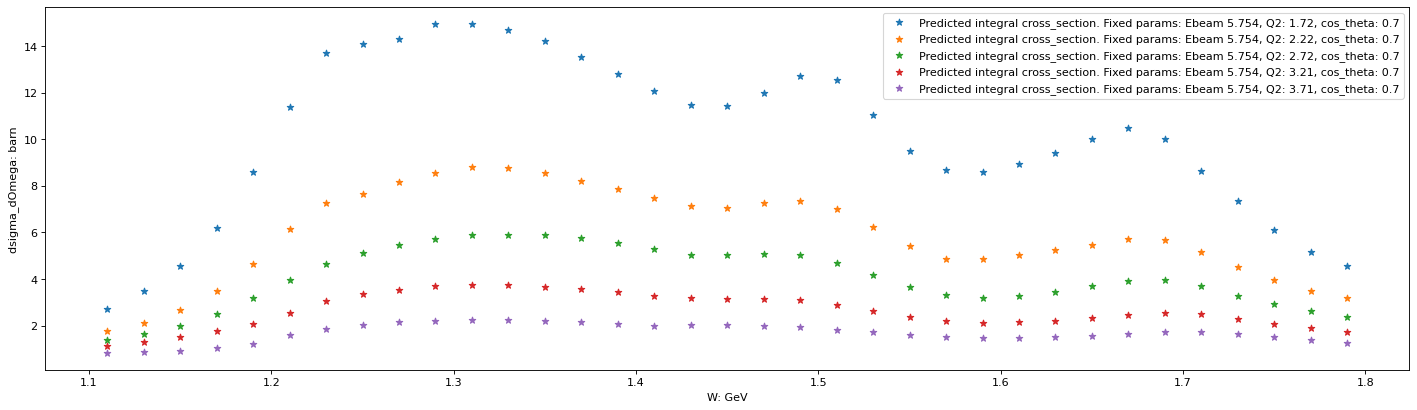

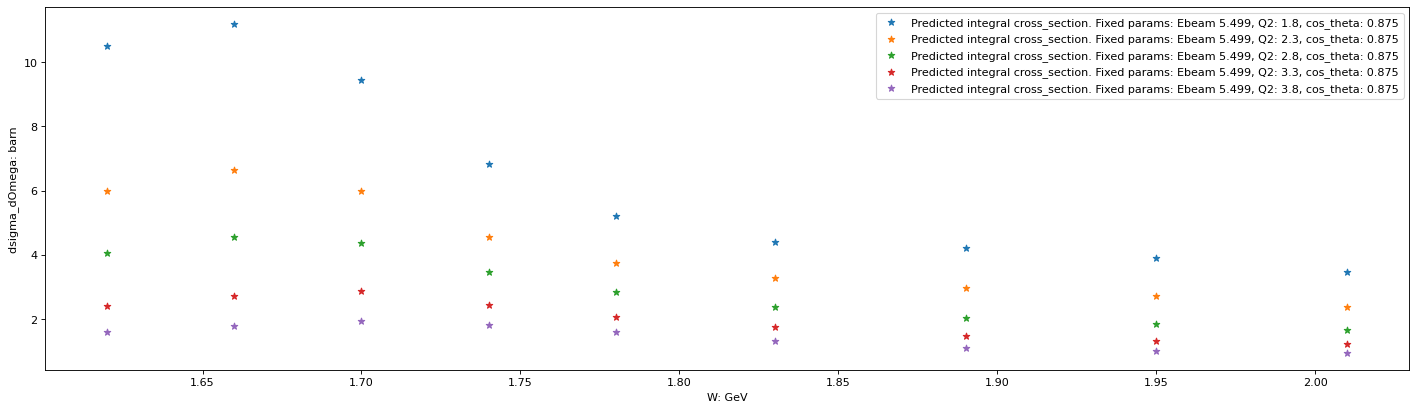

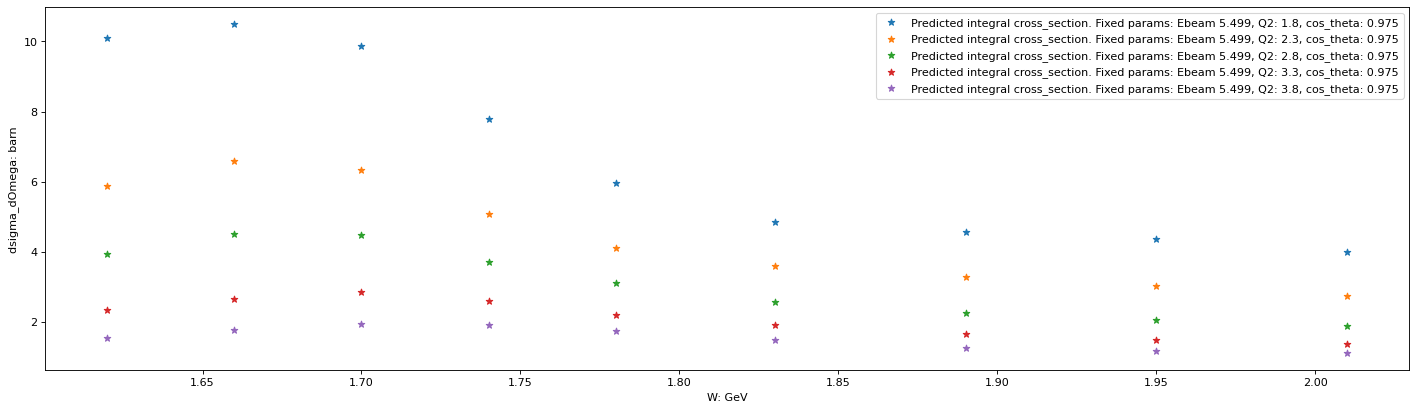

KeyboardInterrupt: 

In [63]:
for _ in range(30):
    integral_cross_section_W_Q2()

# Structure functions

In [25]:
# df_grid
Ebeam = 5.754
step_W = 0.005
step_Q2 = 0.1
step_cos_theta = 0.1
step_phi = 0.05


data_grid = []
for W in tqdm.tqdm(np.arange(1.1, 2.2 + step_W, step_W)):
    for Q2 in np.arange(1.6, 4.3 + step_Q2, step_Q2):
         for cos_theta in np.arange(-1, 1+step_cos_theta, step_cos_theta):
                for phi in np.arange(0, 2*np.pi, step_phi):
                    data_grid.append([Ebeam,
                                      W,
                                      Q2,
                                      cos_theta, 
                                      phi])
                    
df_grid = pd.DataFrame(data_grid)
df_grid.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']


df_grid.W = np.round(df_grid.W, 3)
df_grid.Q2 = np.round(df_grid.Q2, 3)
df_grid.cos_theta = np.round(df_grid.cos_theta, 3)
df_grid.phi = np.round(df_grid.phi, 3)

In [26]:
df_grid_parts = np.array_split(df_grid, 100)
df_grid_parts_preds = []
for df_grid_part in tqdm.tqdm(df_grid_parts):
    dsigma_dOmega_predicted = model.forward(torch.tensor(df_grid_part.to_numpy(),dtype=torch.float32)).detach()

    df_grid_part['dsigma_dOmega_predicted'] = dsigma_dOmega_predicted
    df_grid_part.dsigma_dOmega_predicted = abs(df_grid_part.dsigma_dOmega_predicted)

    df_grid_part['A'] = 0
    df_grid_part['B'] = 0
    df_grid_part['C'] = 0
    df_grid_parts_preds.append(df_grid_part)

100%|██████████| 100/100 [09:50<00:00,  5.90s/it]


In [29]:
df_grid = pd.concat(df_grid_parts_preds)

In [61]:
phi_min_index = df_grid[df_grid.phi == df_grid.phi.min()].index.to_numpy()
phi_max_index = df_grid[df_grid.phi == df_grid.phi.max()].index.to_numpy()

In [62]:
for i in tqdm.tqdm(range(len(phi_min_index))):
    cross_section_chunk = df_grid.iloc[phi_min_index[i]:phi_max_index[i]].dsigma_dOmega_predicted
    cos_phi = np.cos(df_grid.iloc[phi_min_index[i]:phi_max_index[i]].phi)
    cos_2_phi = np.cos(2*df_grid.iloc[phi_min_index[i]:phi_max_index[i]].phi)
    
    trapz_A = np.trapz(cross_section_chunk, dx=step_phi)
    trapz_B = np.trapz(cross_section_chunk*cos_2_phi, dx=step_phi)
    trapz_C = np.trapz(cross_section_chunk*cos_phi, dx=step_phi)
    
    A = trapz_A/(2*np.pi)
    B = trapz_B/(np.pi)
    C = trapz_C/(np.pi)
    
    df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
    df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
    df_grid.loc[phi_min_index[i]:phi_max_index[i], 'C'] = C

100%|██████████| 129948/129948 [02:07<00:00, 1016.77it/s]


##### Almaz data

In [32]:
df_a = pd.read_csv('../data/final_table.csv', header=None, sep='\t',
                    names=['Channel', 'MID', 'Wmin', 'Wmax', 'Q2min', 'Q2max', 'Cos(theta)', 'sigma_t', 'd_sigma_t',
                    'sigma_l', 'd_sigma_l', 'sigma_tt', 'd_sigma_tt', 'sigma_lt', 'd_sigma_lt', 'eps'])
df_a = df_a[df_a.Channel.isin([8, 14, 41, 141])]
df_a['W'] = (df_a['Wmax'] + df_a['Wmin'])/2
df_a['Q2'] = (df_a['Q2max'] + df_a['Q2min'])/2
df_a['cos_theta'] = df_a['Cos(theta)']

In [33]:
def gen_ABC_W(Ebeam, Q2, cos_theta):
    
    df_tmp = df_grid[(df_grid.Ebeam == Ebeam)&
                    (df_grid.Q2 == Q2)&
                    (df_grid.cos_theta == cos_theta)].drop(['phi', 'dsigma_dOmega_predicted'], axis=1).drop_duplicates()
    
    return df_tmp

def real_almaz_ABC_W(Q2, cos_theta):
    df_tmp = df_a[(df_a.Q2 == Q2)&(df_a.cos_theta == cos_theta)]
    return df_tmp

def plot_gen_real_almaz(params_gen, params_real):
    params = {'legend.fontsize': 'x-large',
              'figure.figsize': (25, 5),
             'axes.labelsize': 'x-large',
             'axes.titlesize':'x-large',
             'xtick.labelsize':'x-large',
             'ytick.labelsize':'x-large'}
    pylab.rcParams.update(params)
    
    df_ABC_W_gen = gen_ABC_W(**params_gen)
    df_ABC_W_real = real_almaz_ABC_W(**params_real)
    
    
    plt.figure(figsize=(28, 12), dpi=80)

    plt.scatter(df_ABC_W_gen.W, df_ABC_W_gen.A, label= 'AI gen', color='red', s=20, marker='v')

    plt.scatter(df_ABC_W_real.W, df_ABC_W_real.sigma_t + df_ABC_W_real.sigma_l, label= 'real')
    plt.errorbar(df_ABC_W_real.W, df_ABC_W_real.sigma_t + df_ABC_W_real.sigma_l, yerr=df_ABC_W_real.d_sigma_t + df_ABC_W_real.d_sigma_l, fmt='o')

    
    plt.tick_params(axis='both', which='minor', labelsize=20)
    plt.xlabel("W", fontsize=20)
    plt.ylabel("A", fontsize=20)
    plt.title(f'Plot of structure functions. Params gen: {params_gen}. Params real: {params_real}', fontsize=20)
    plt.legend(fontsize=20)
    plt.show()

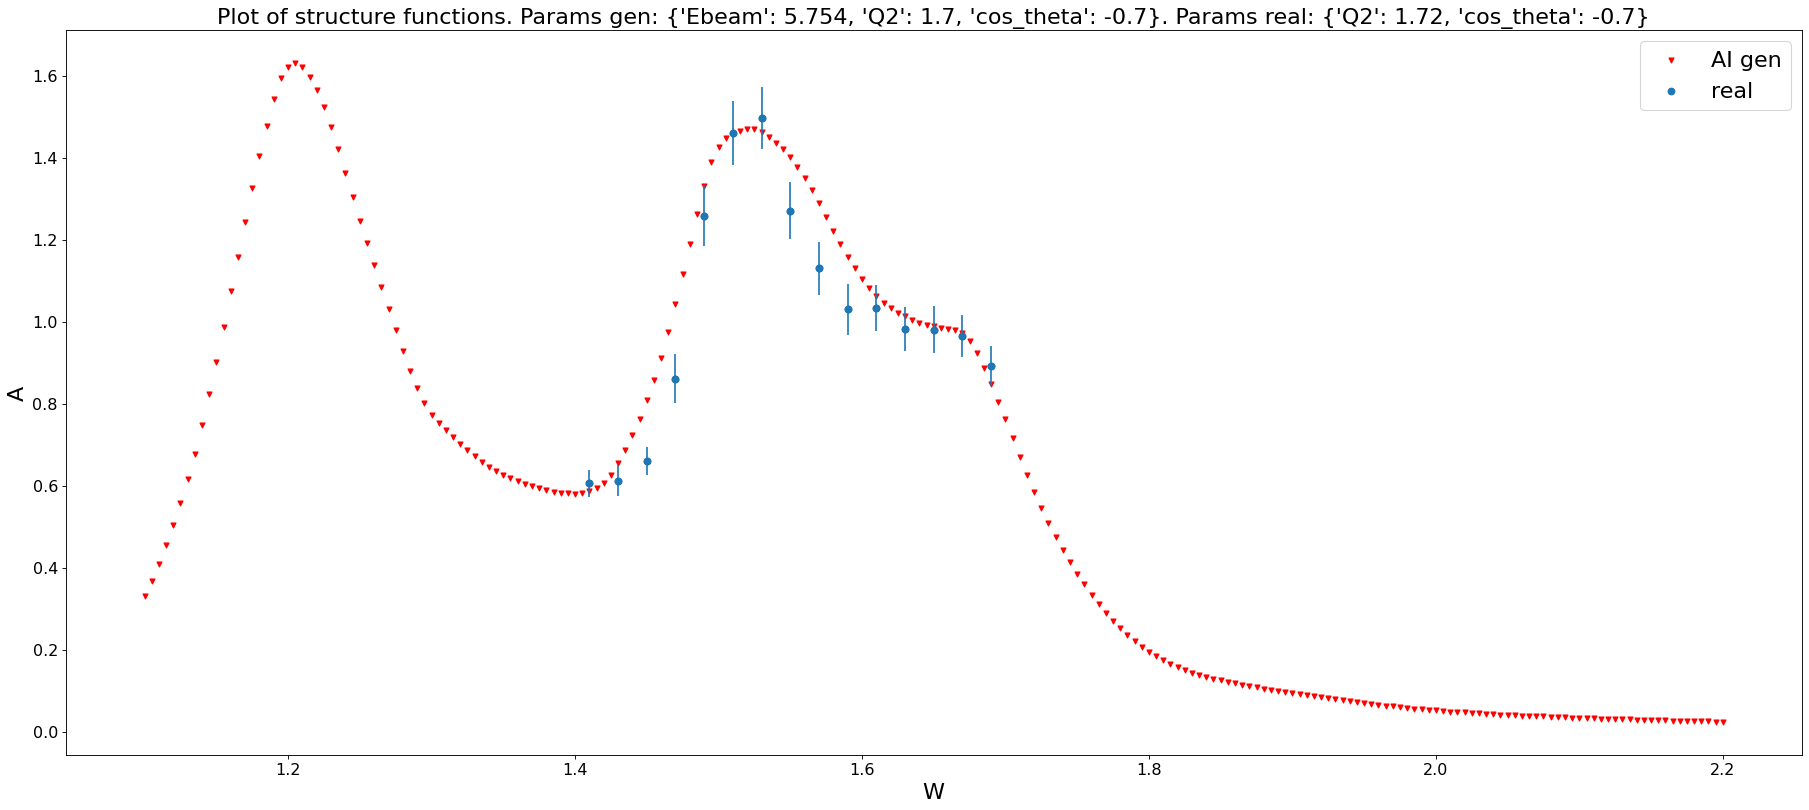

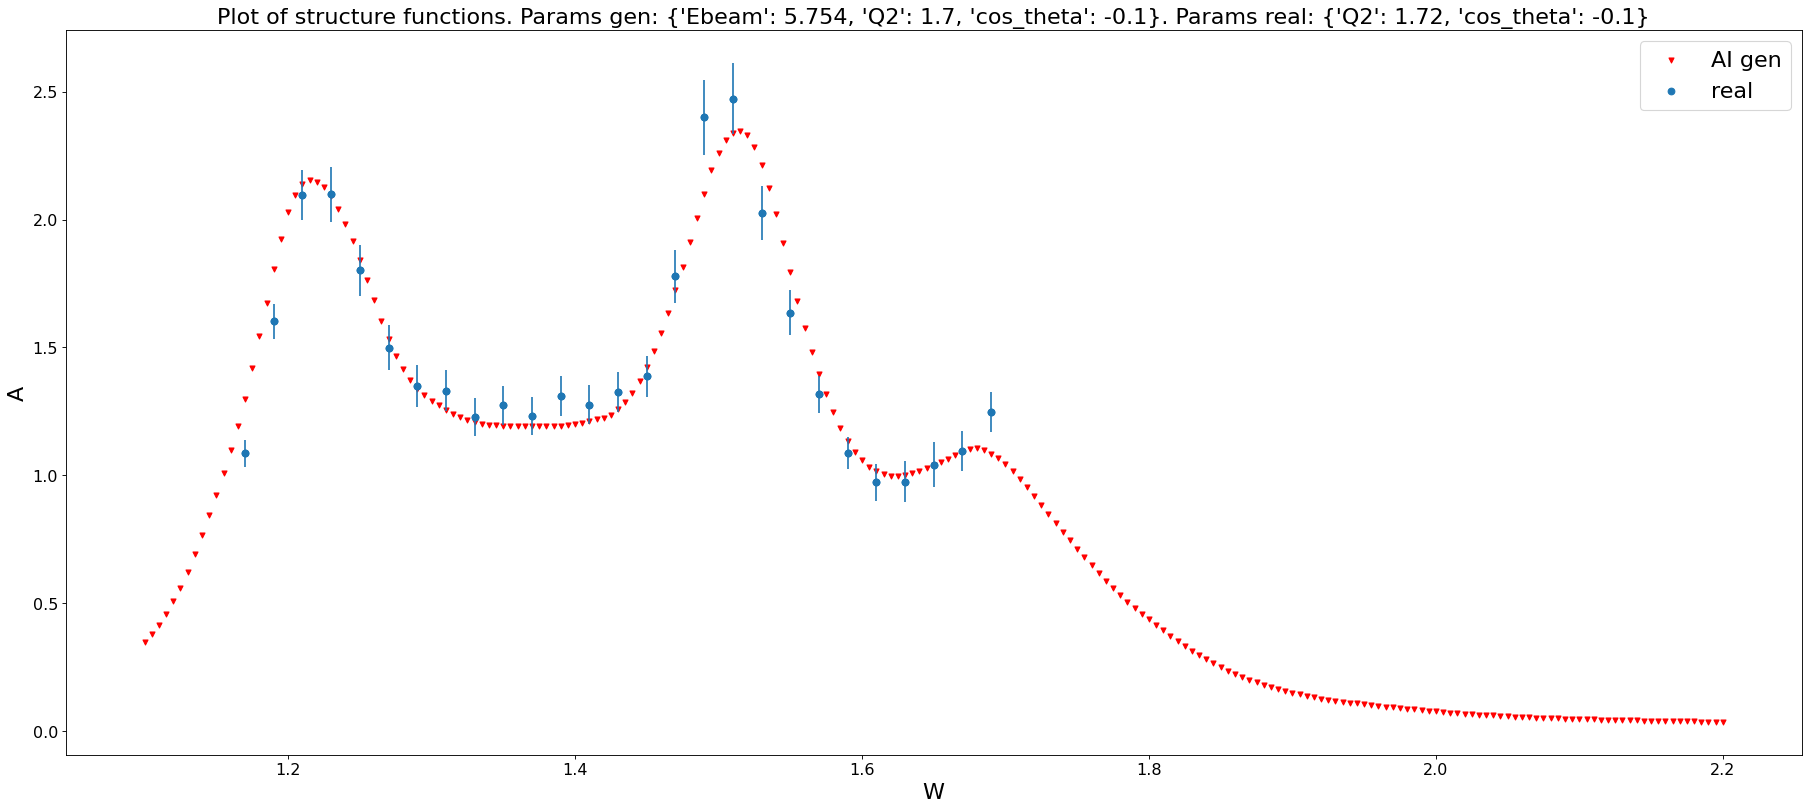

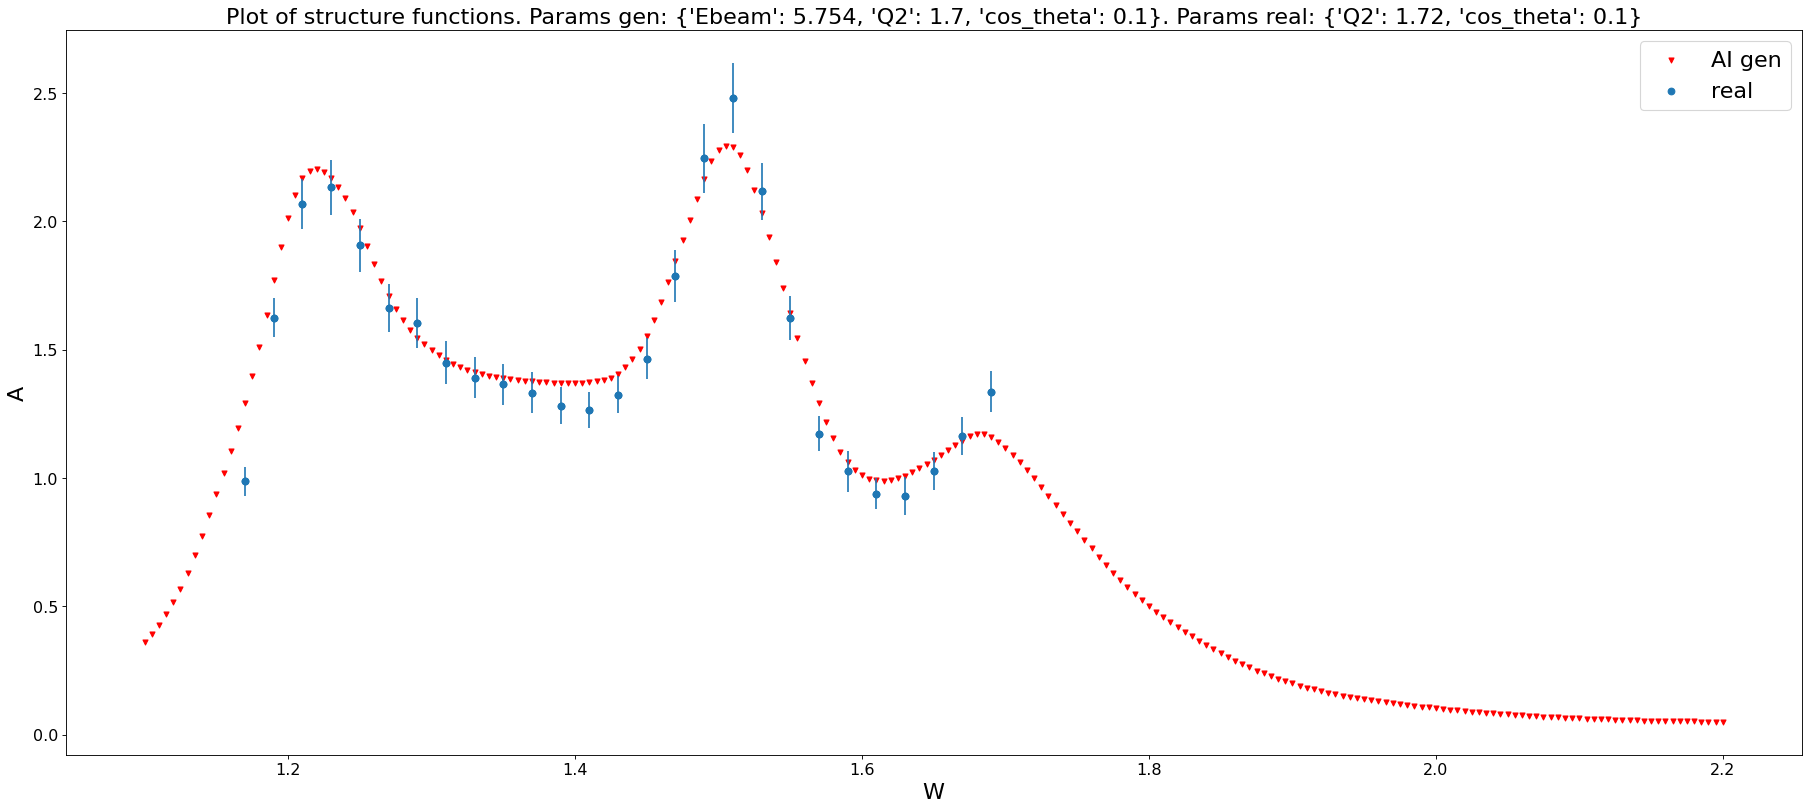

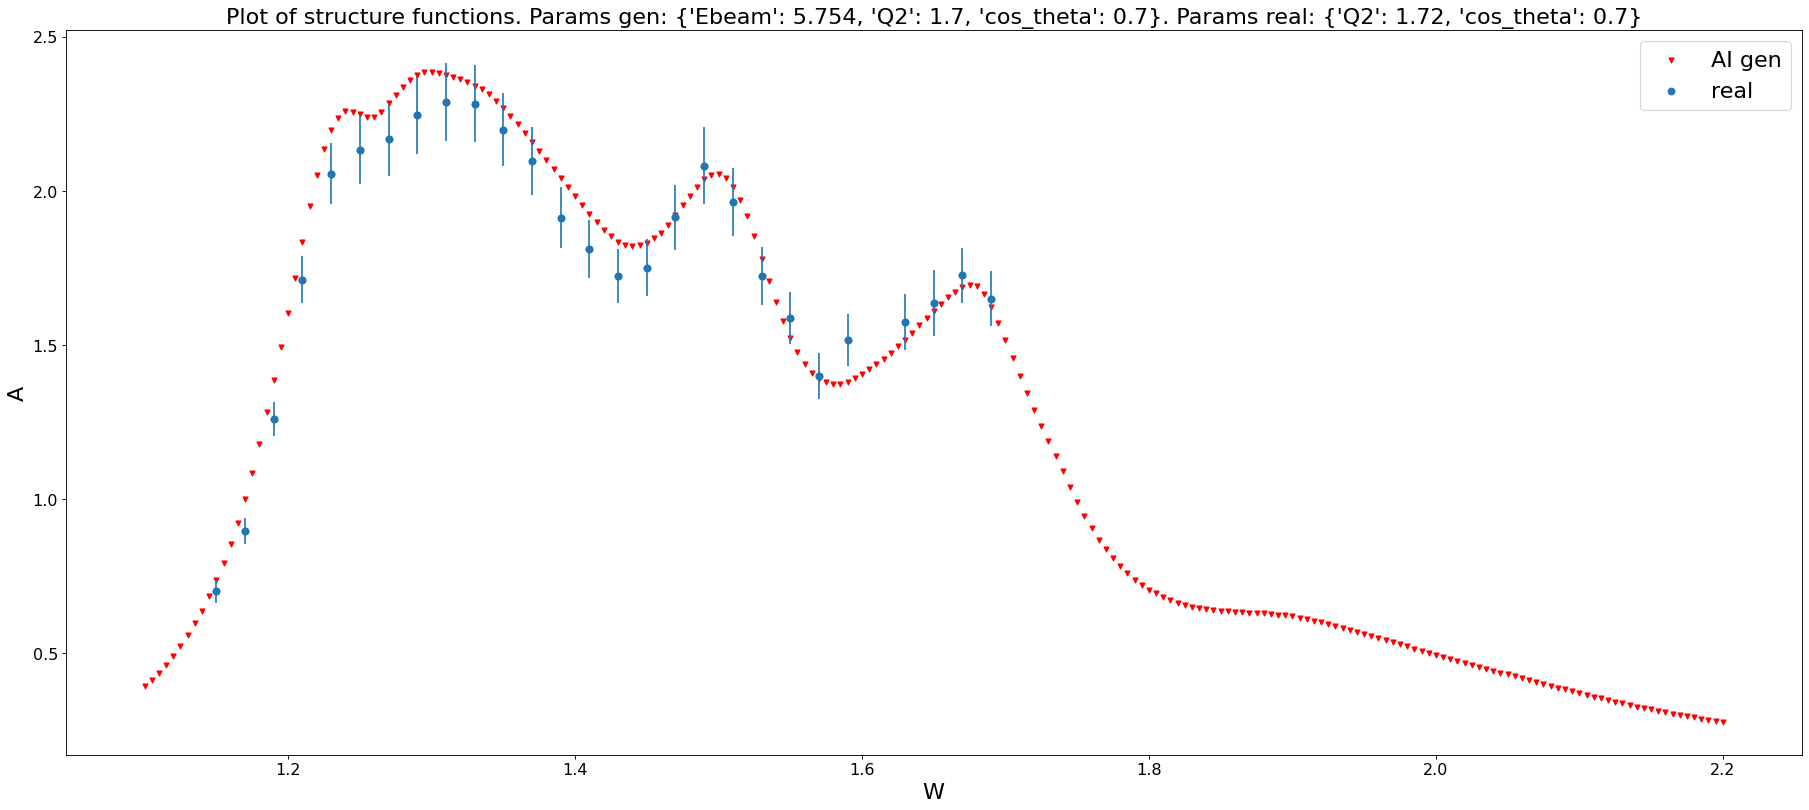

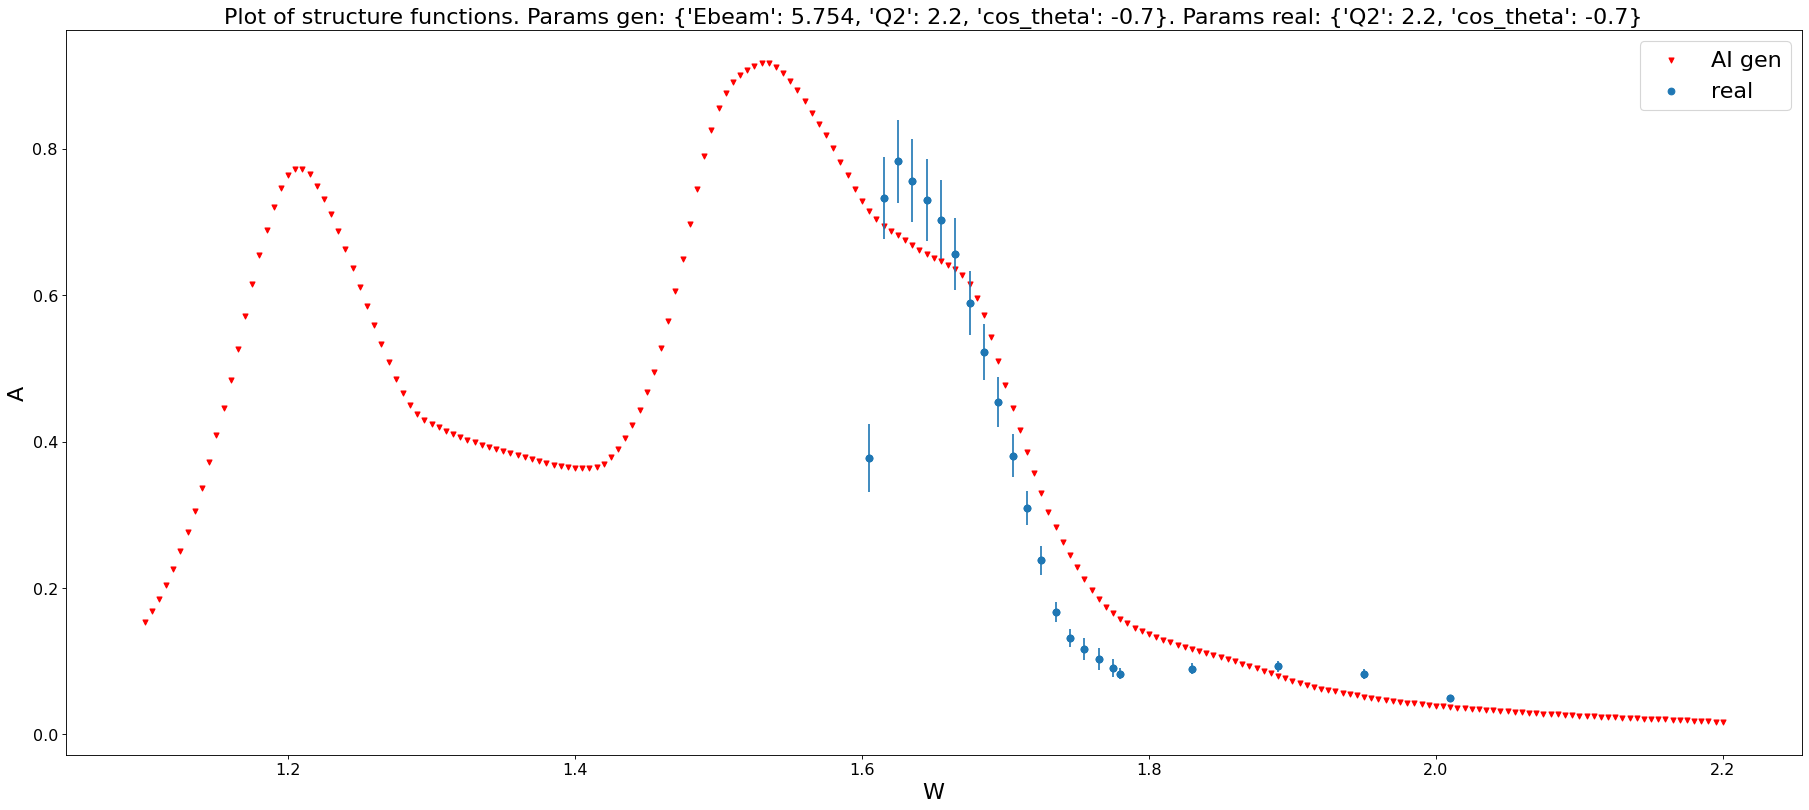

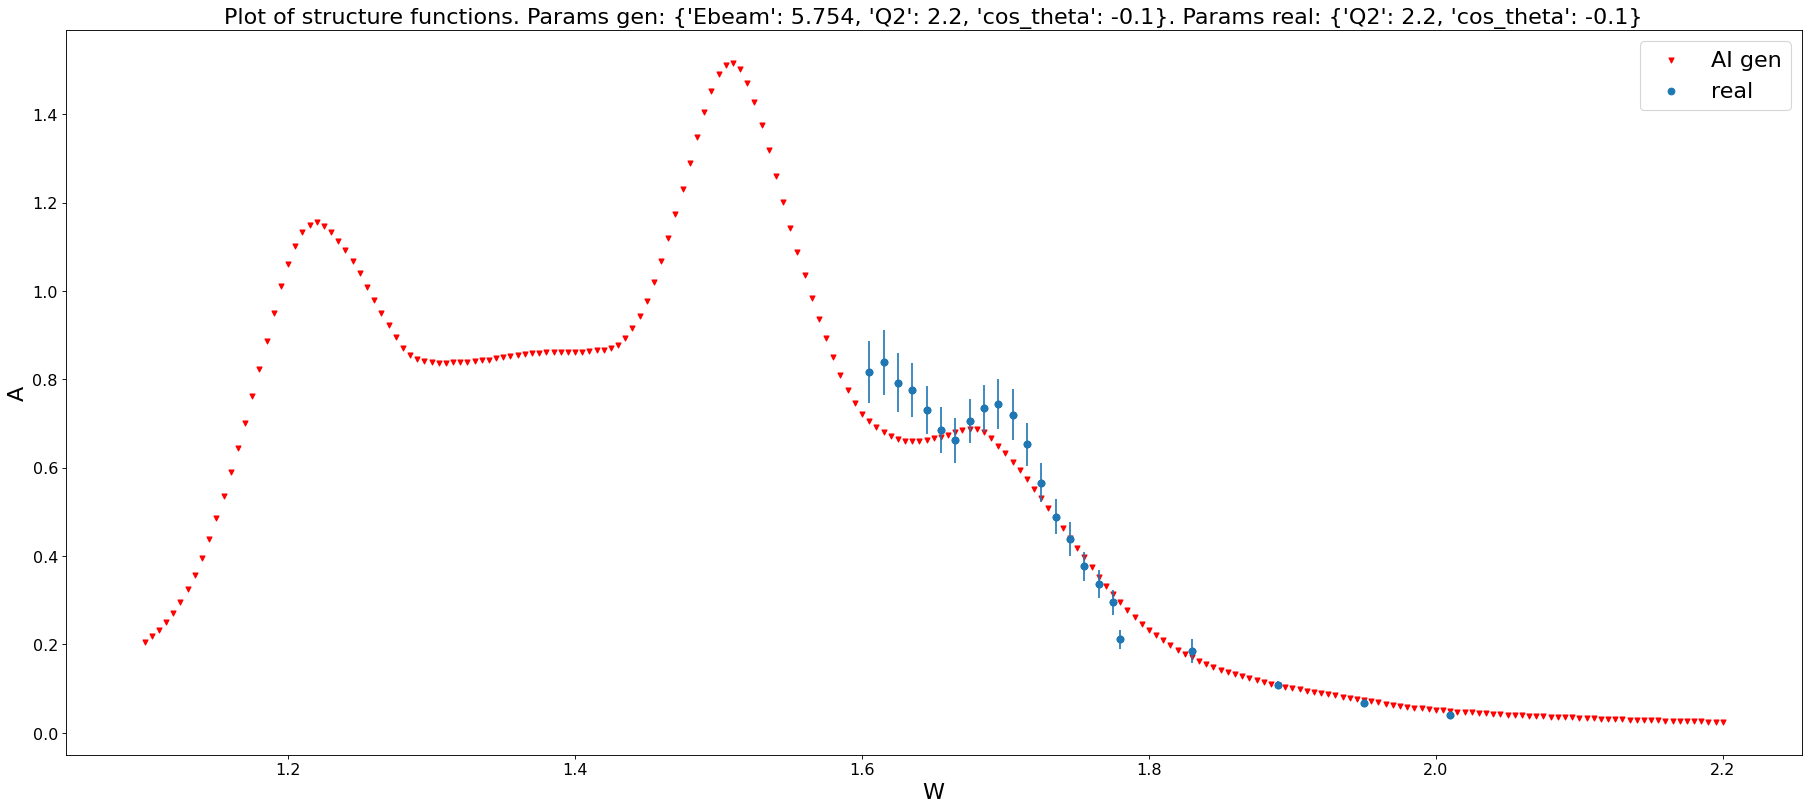

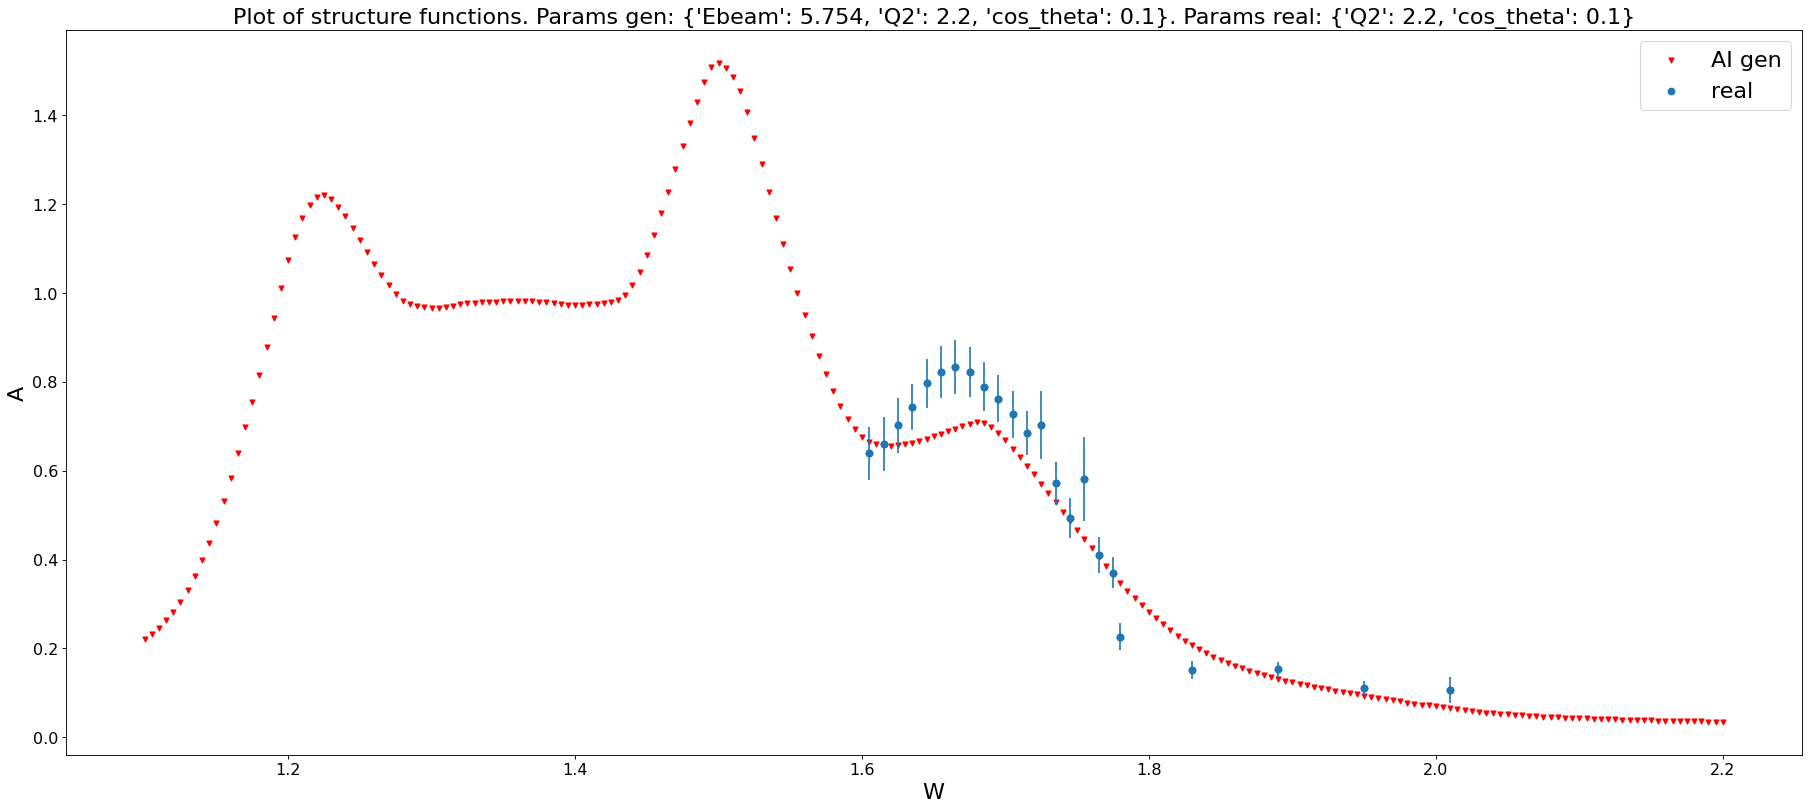

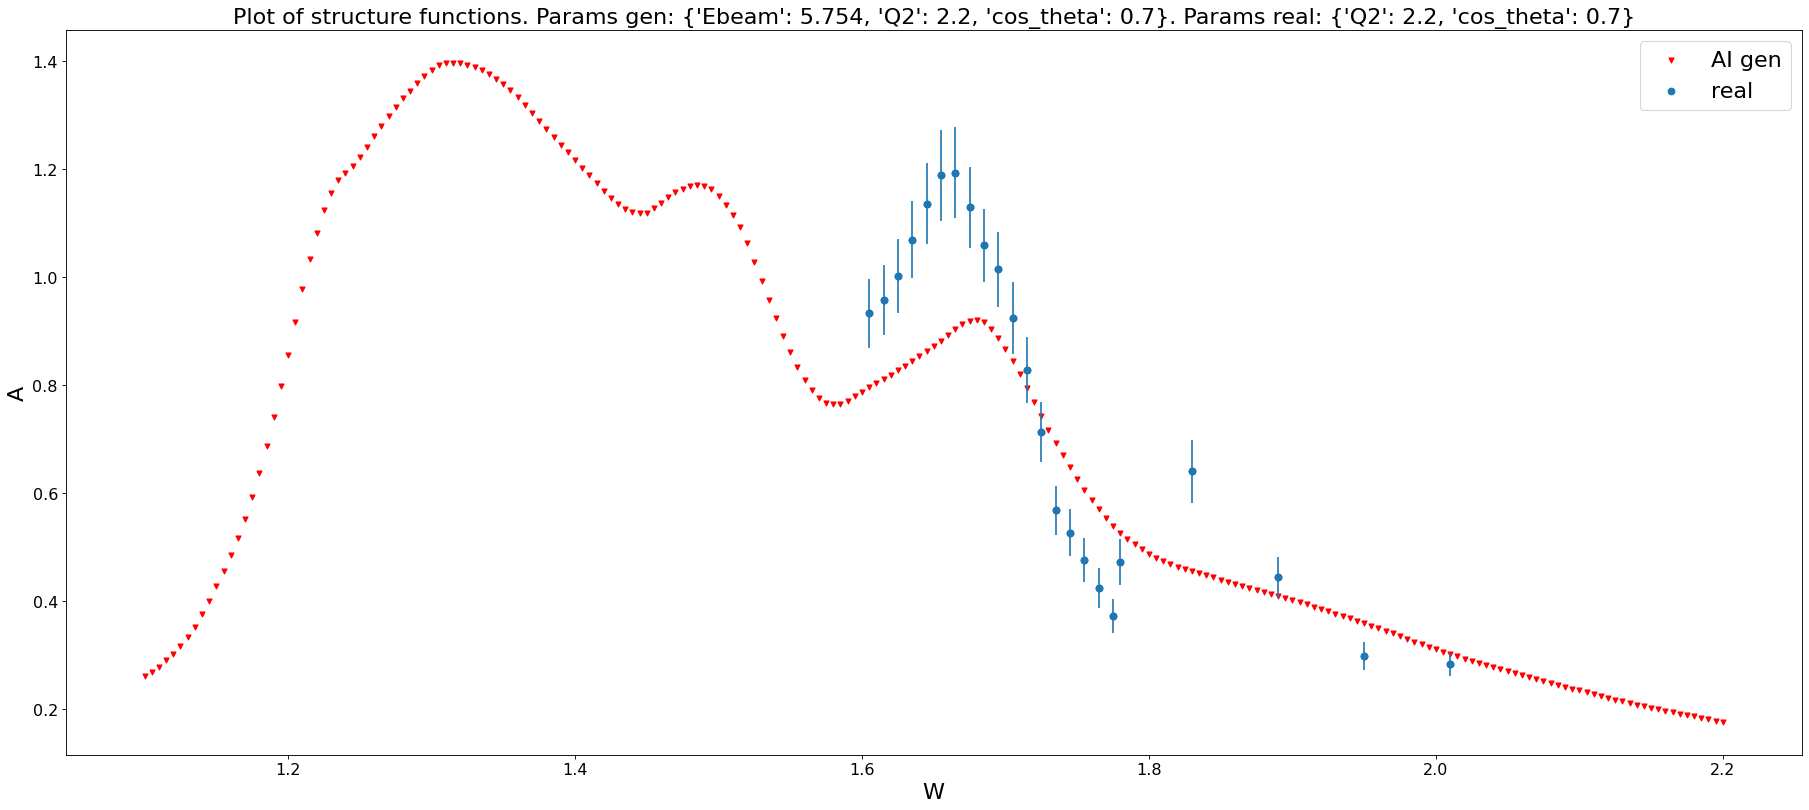

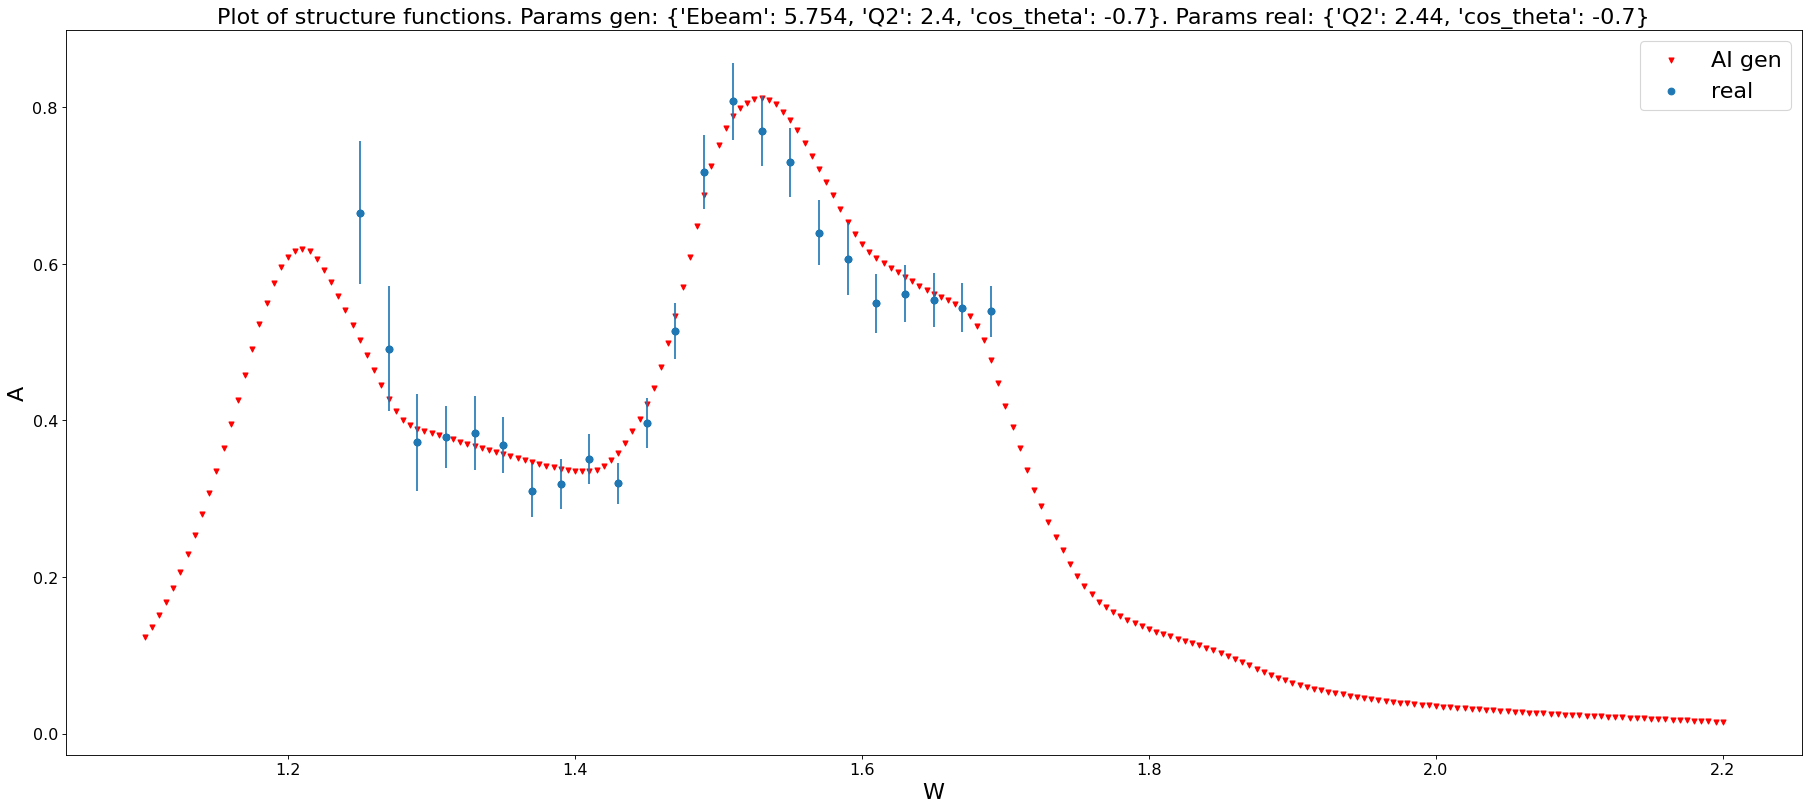

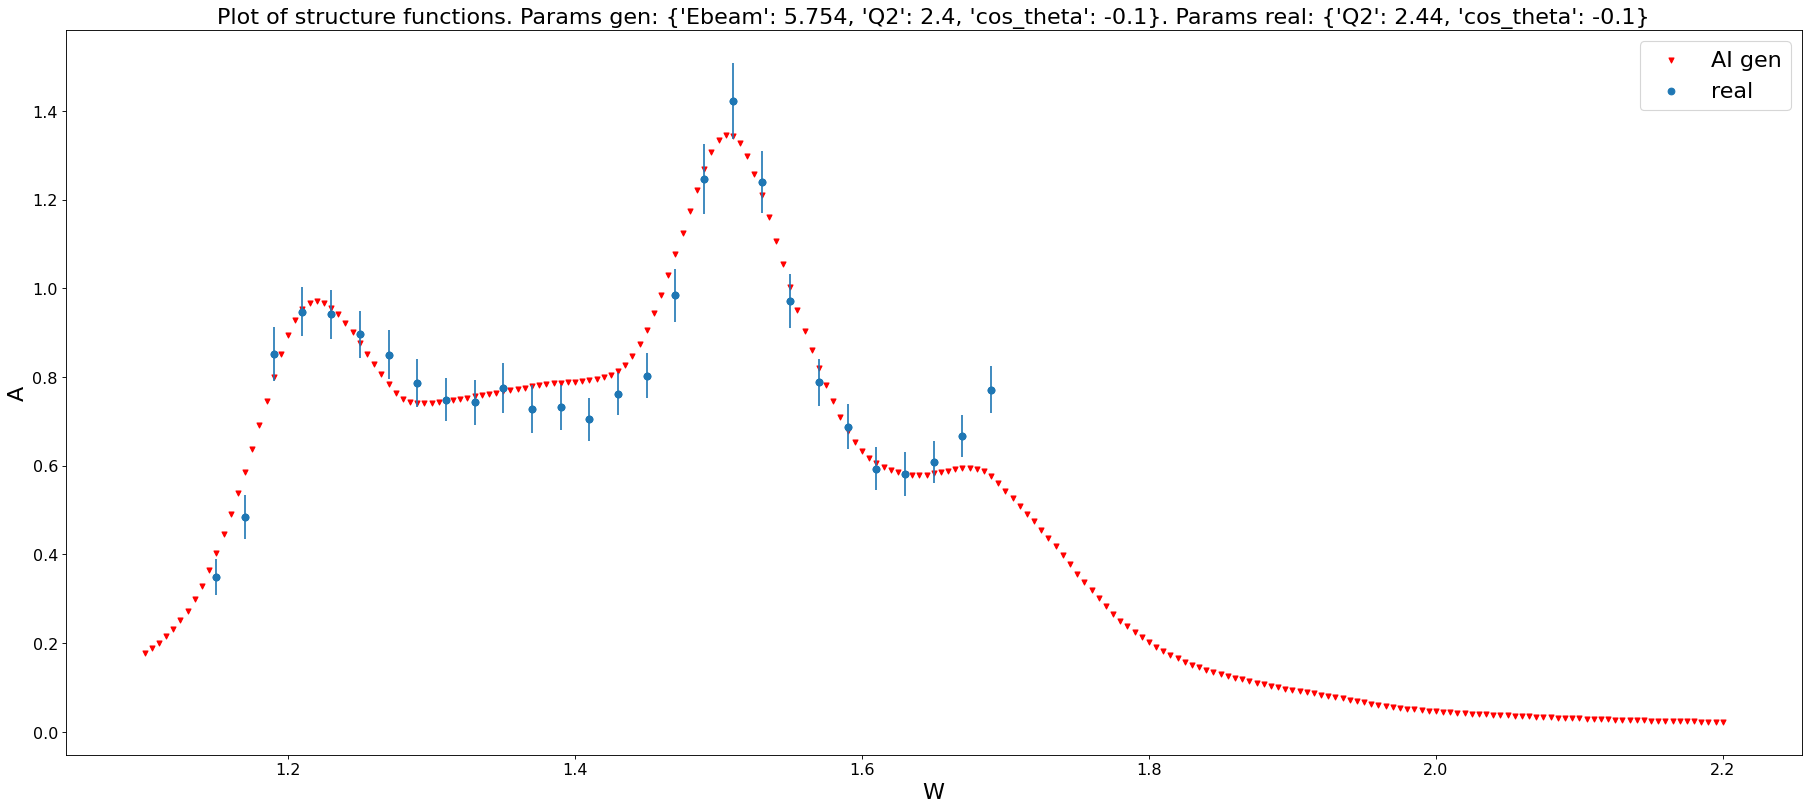

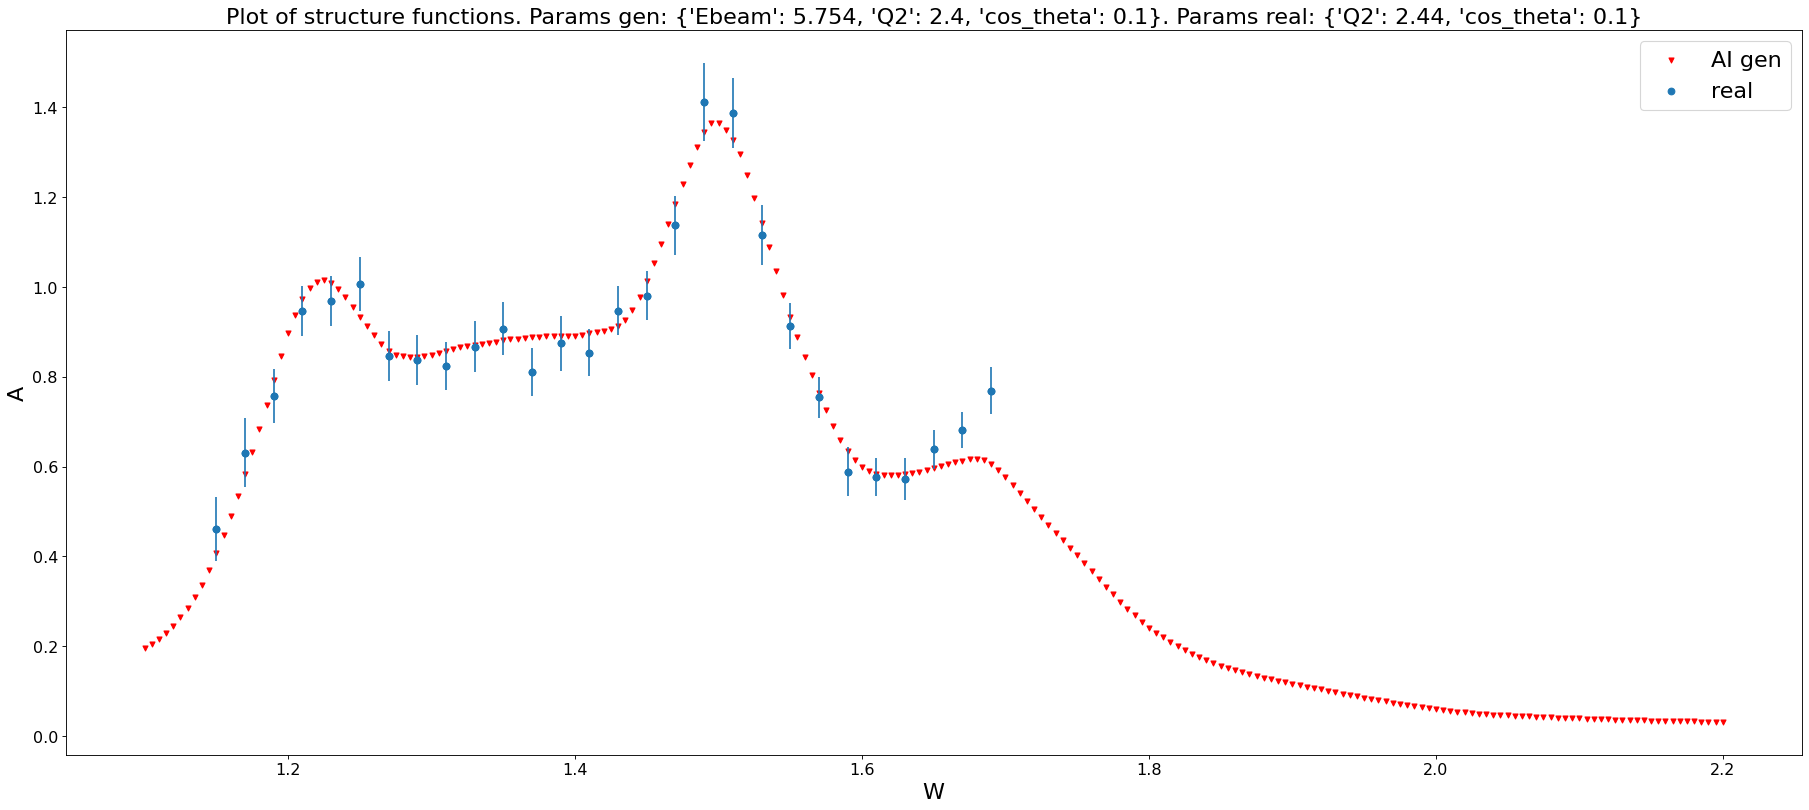

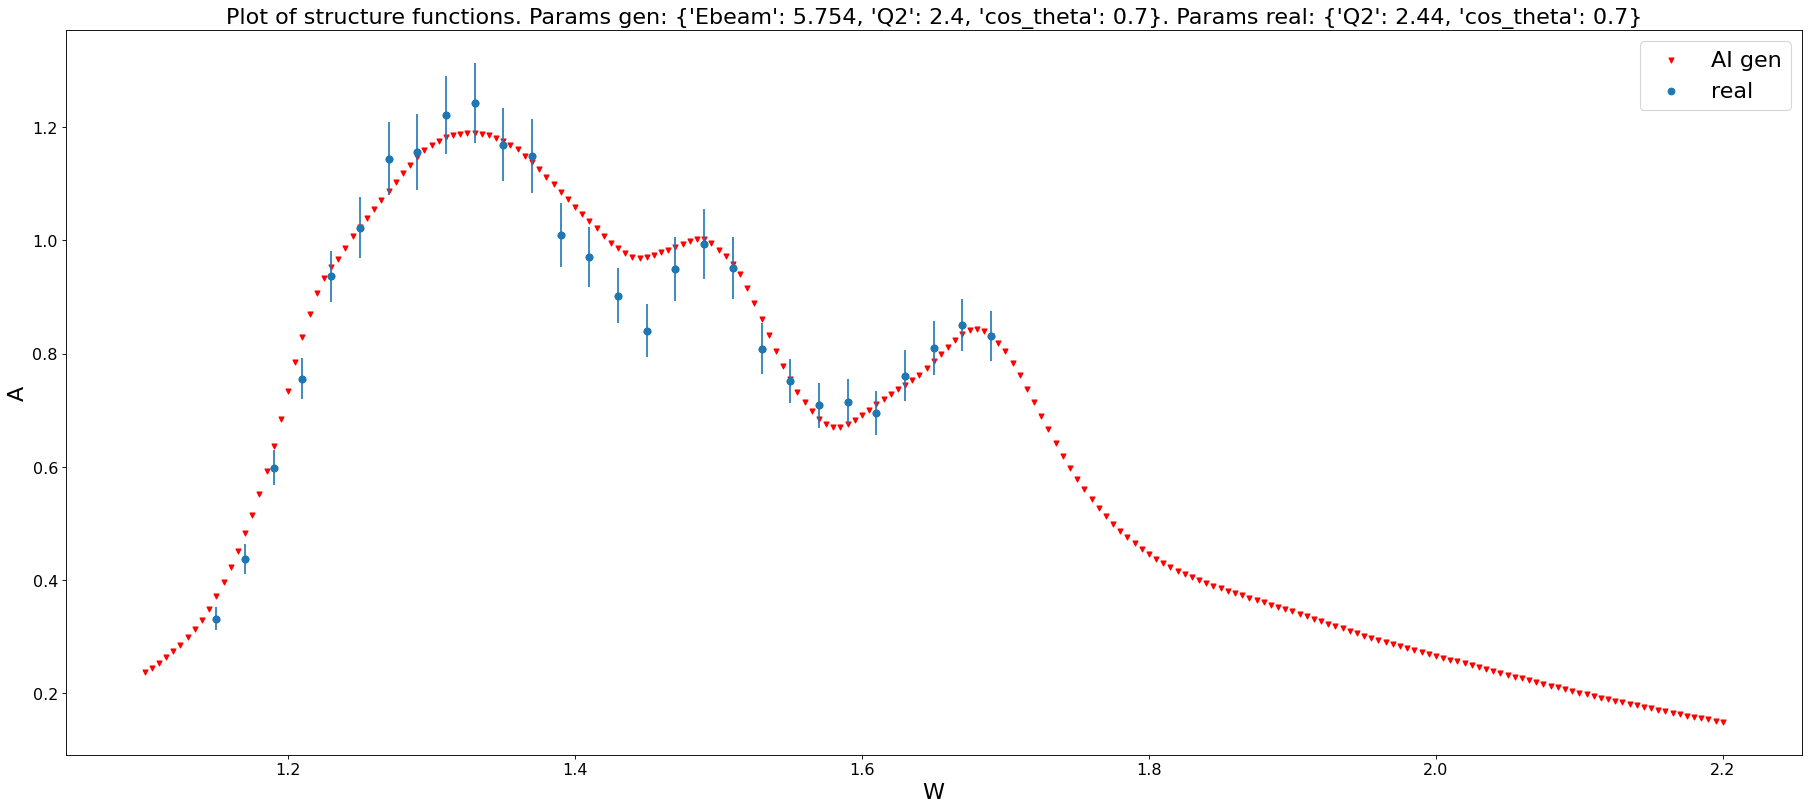

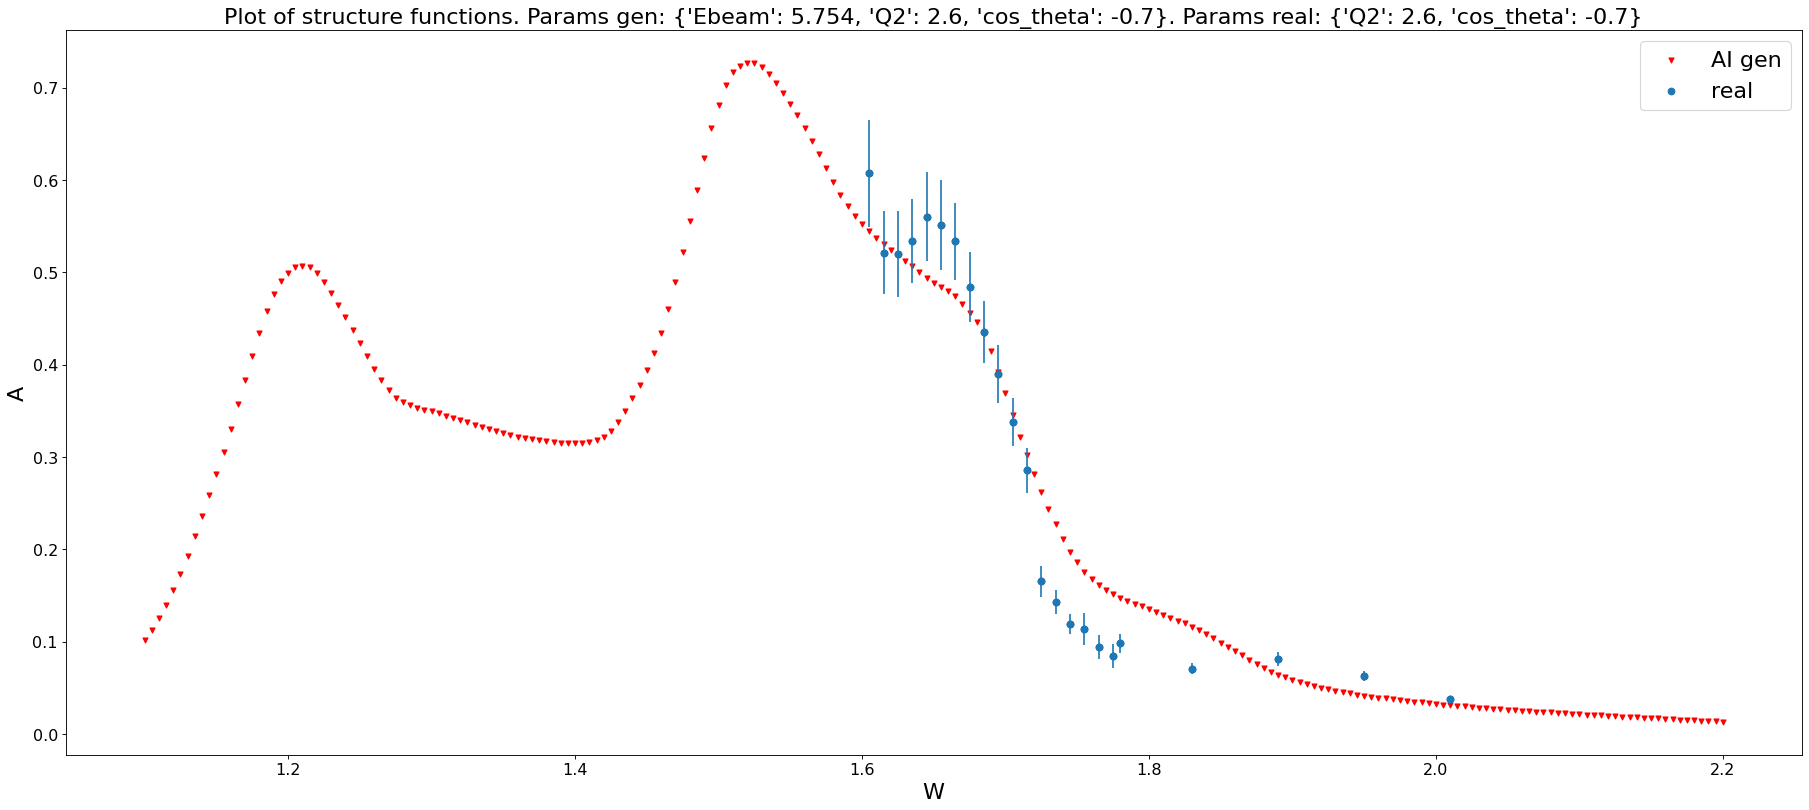

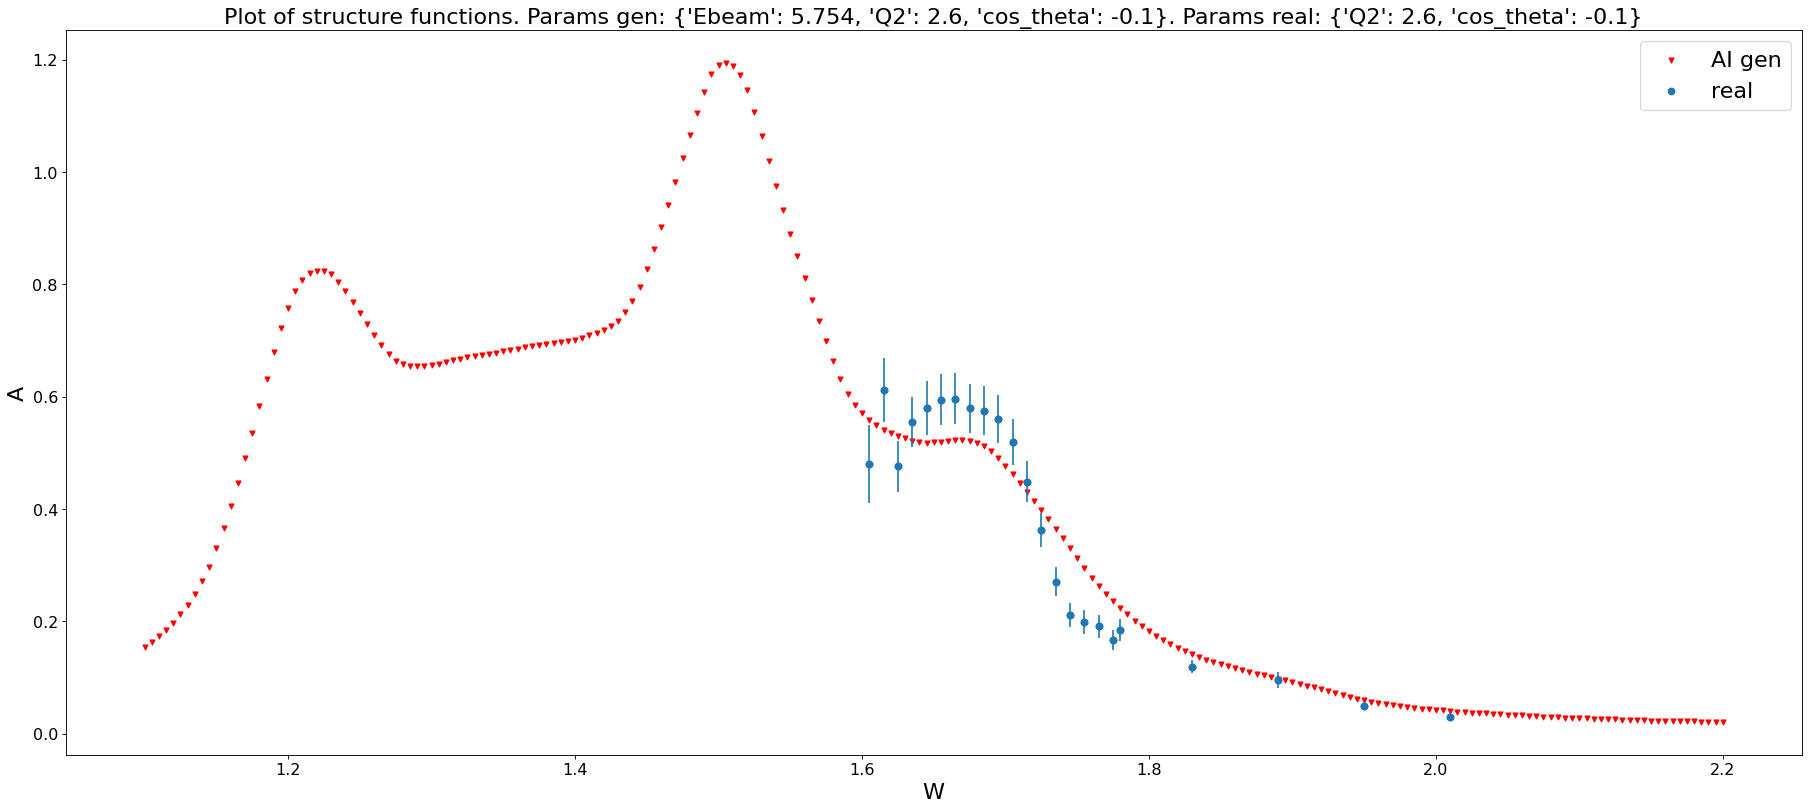

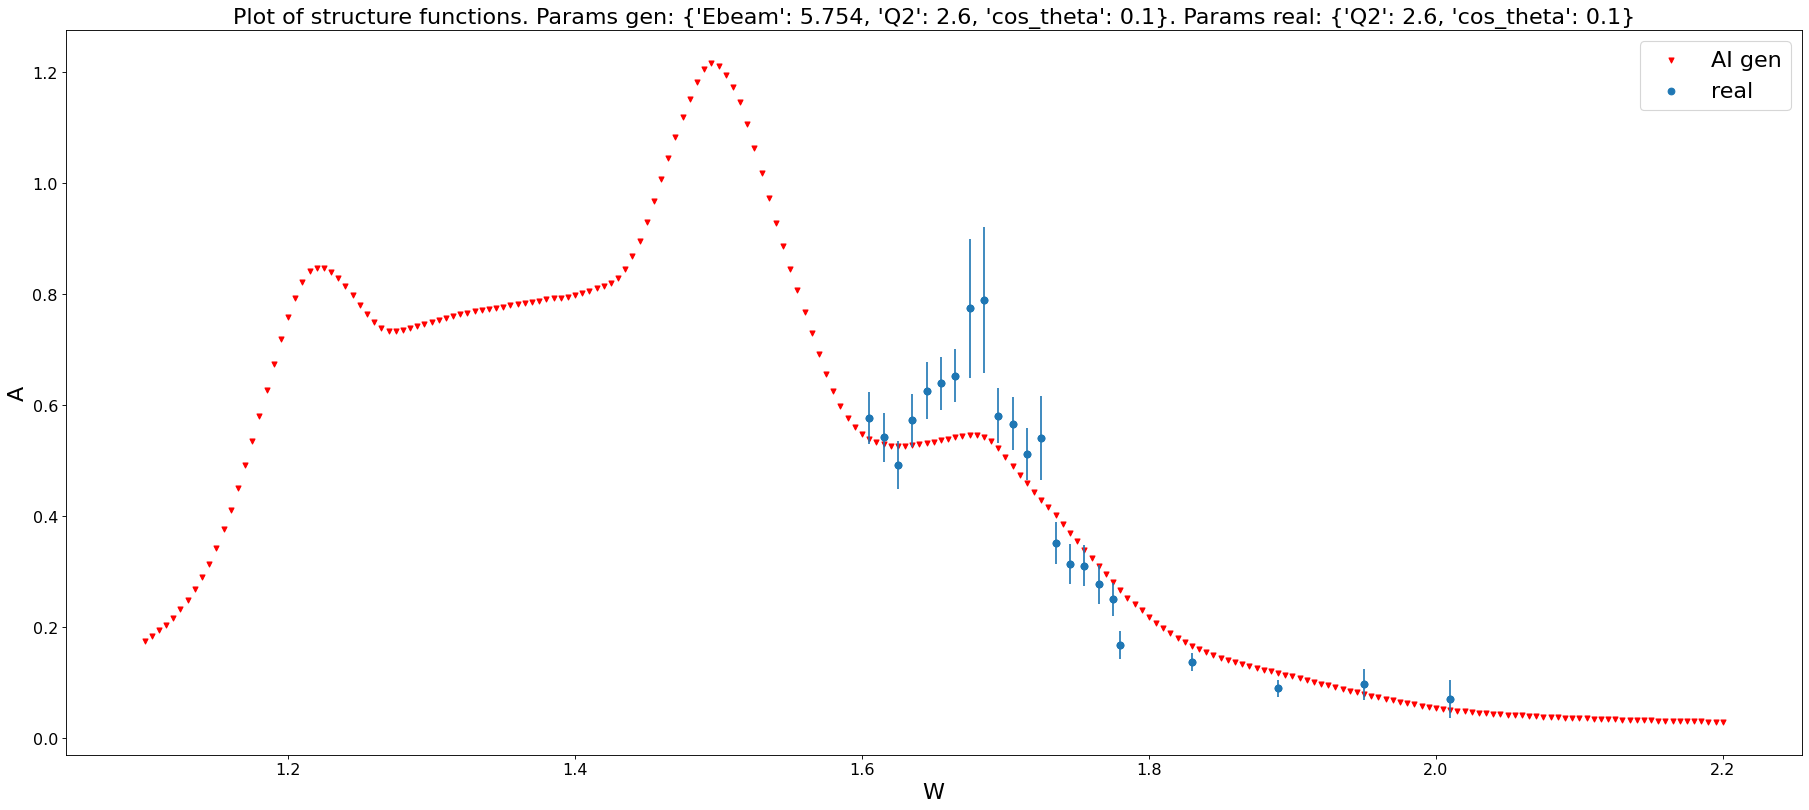

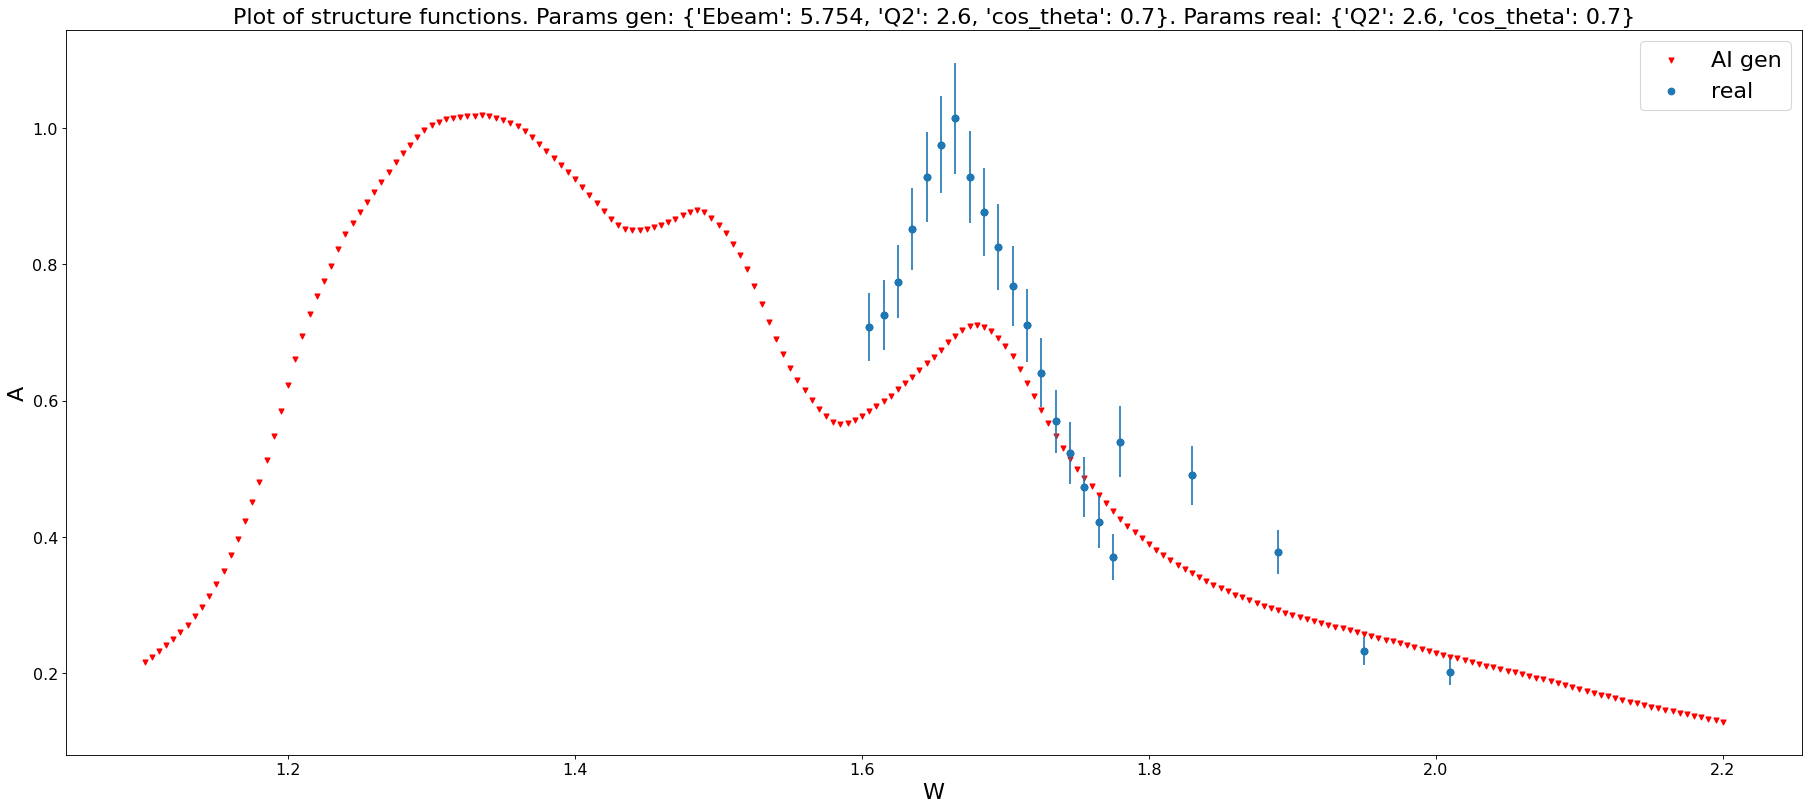

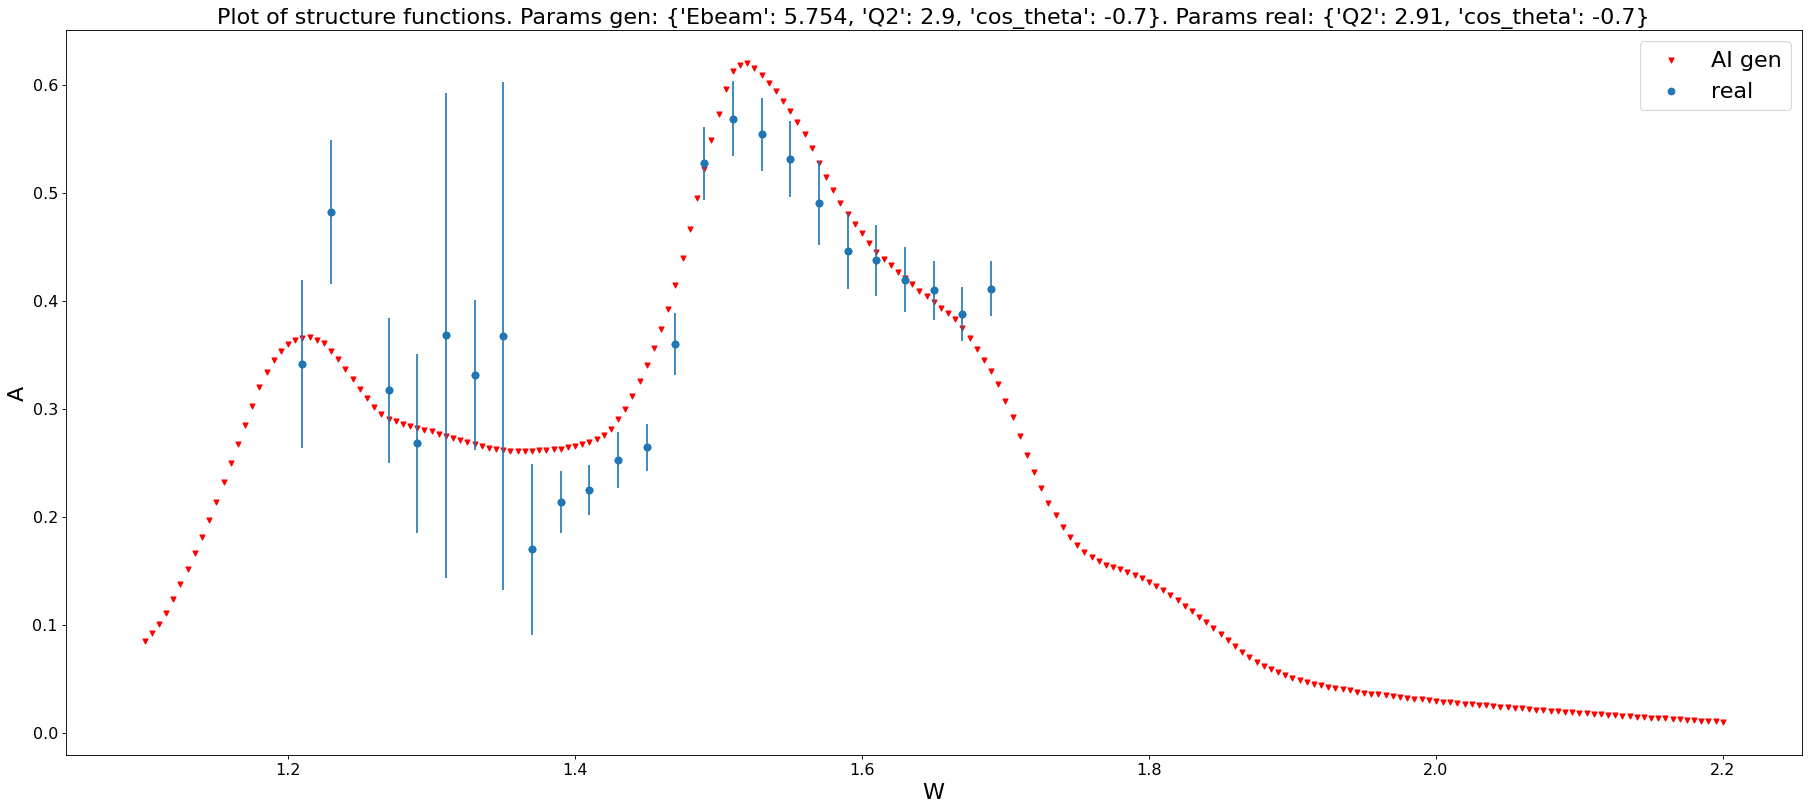

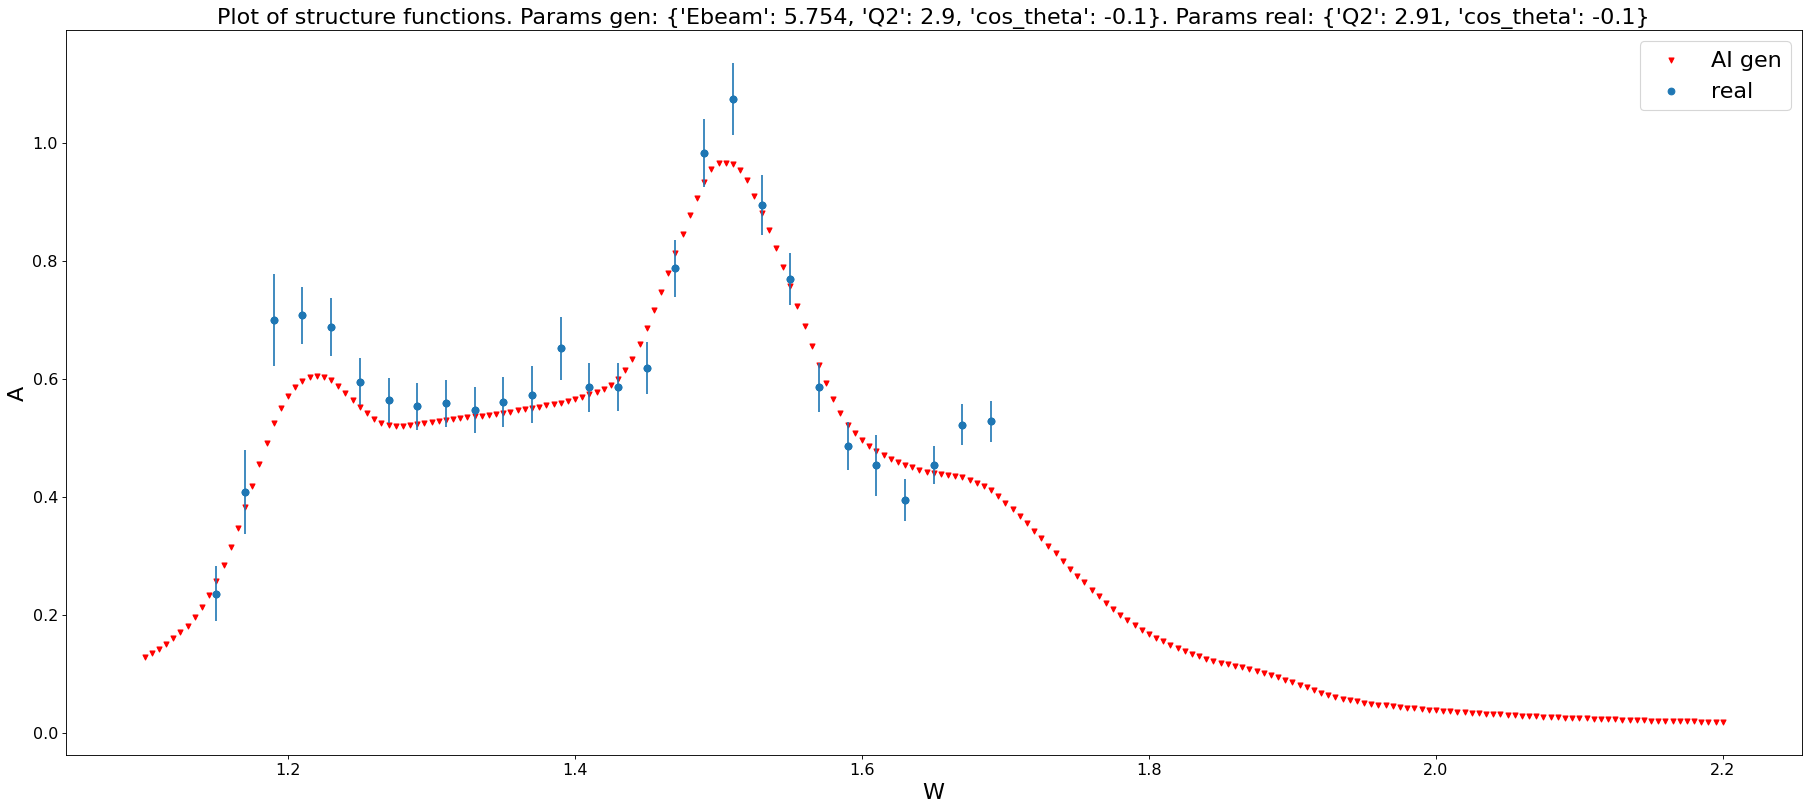

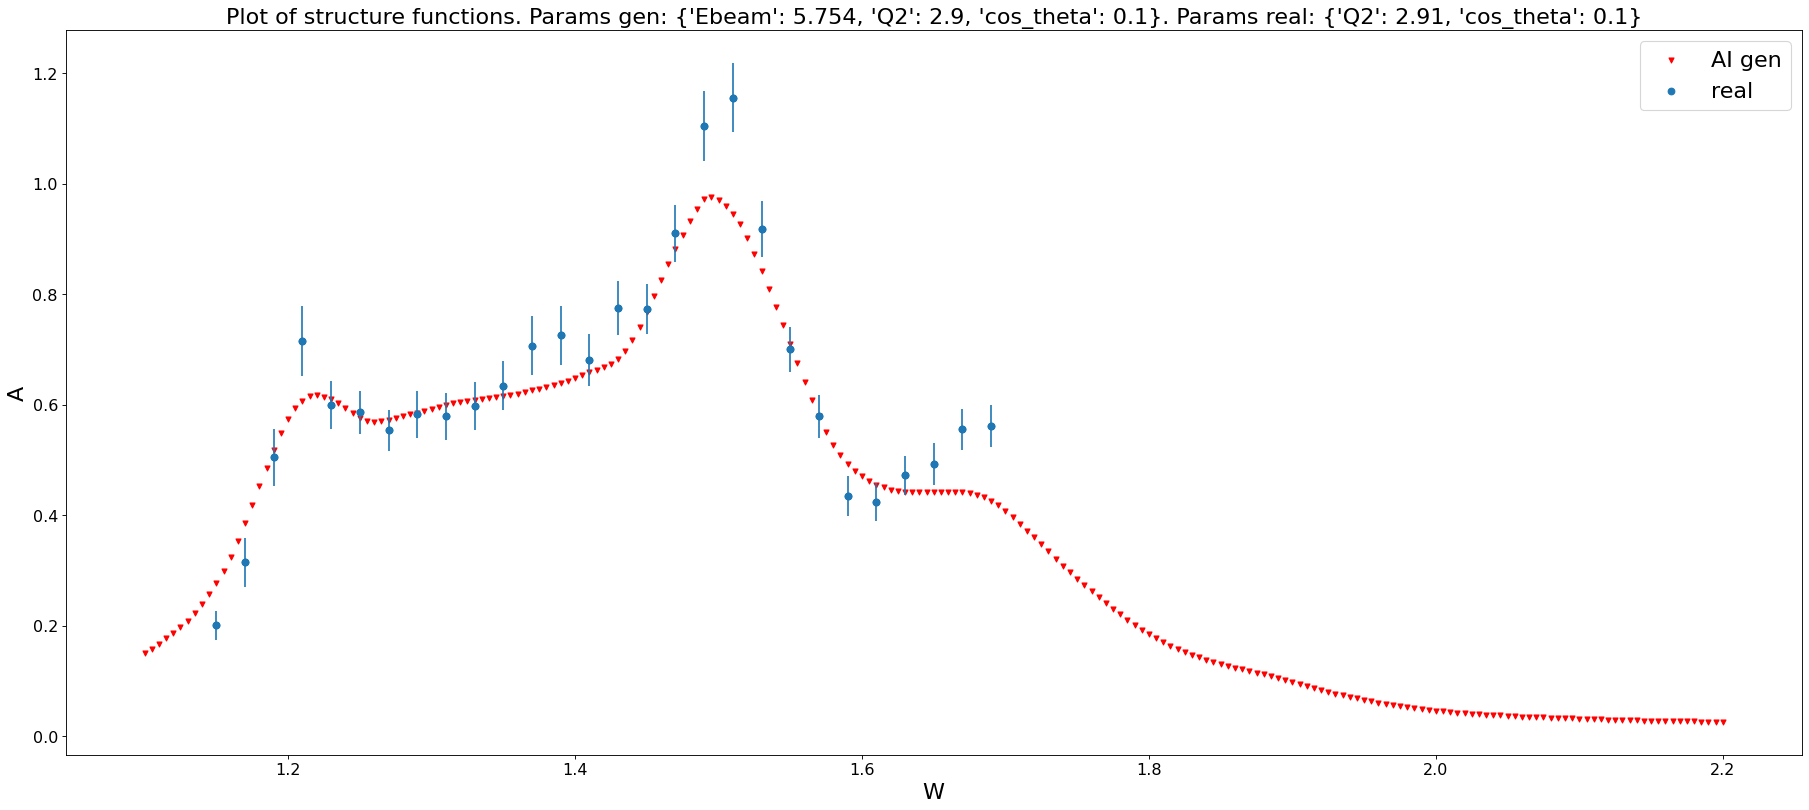

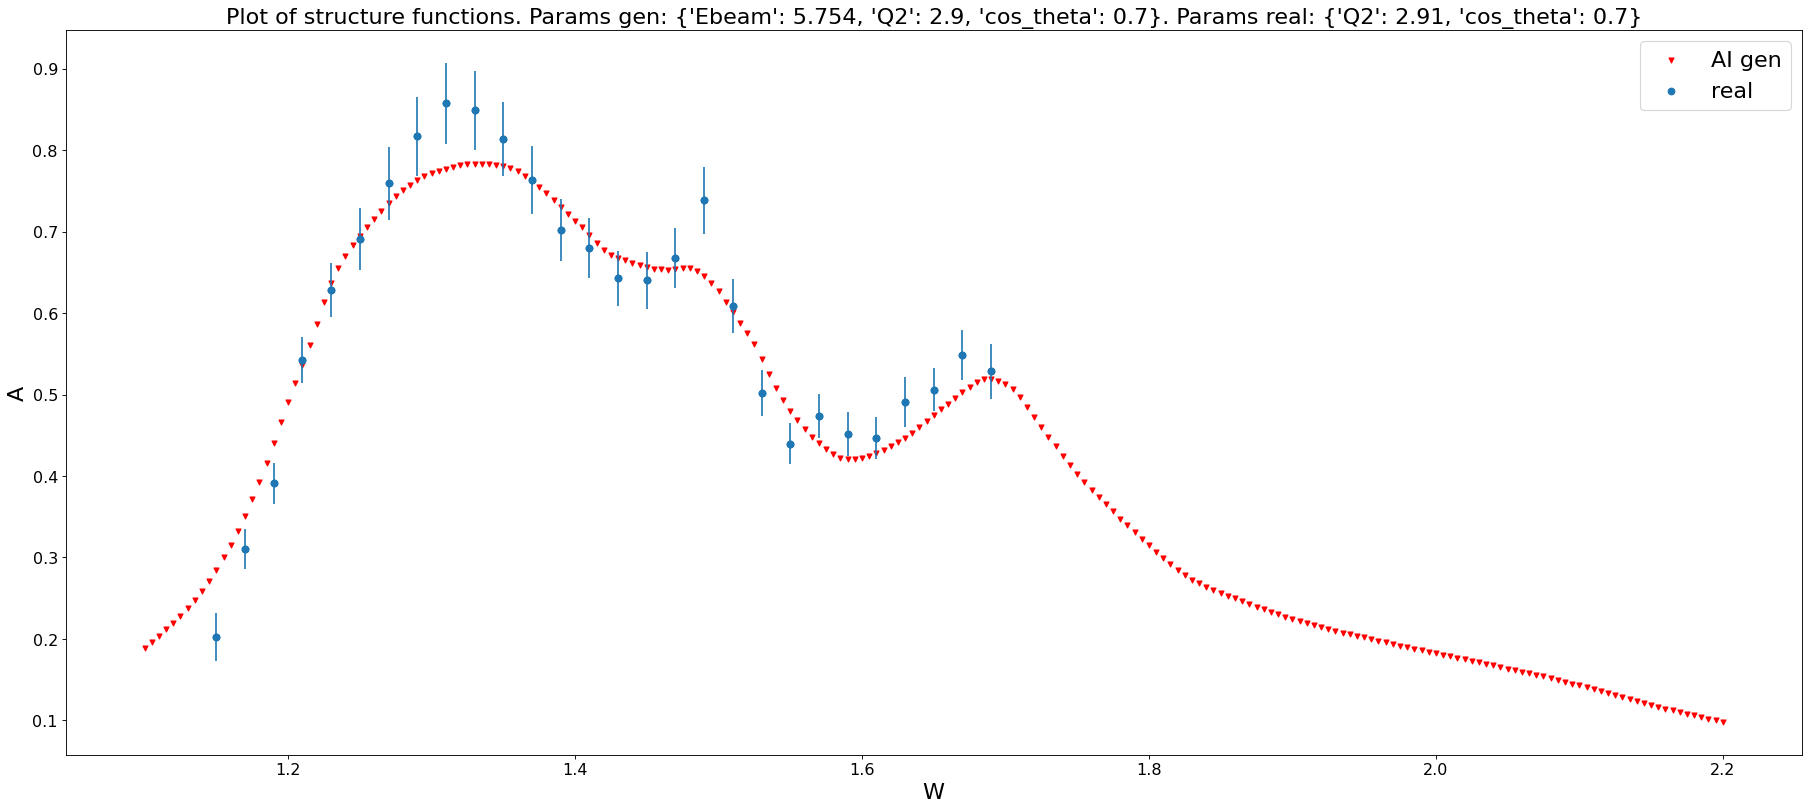

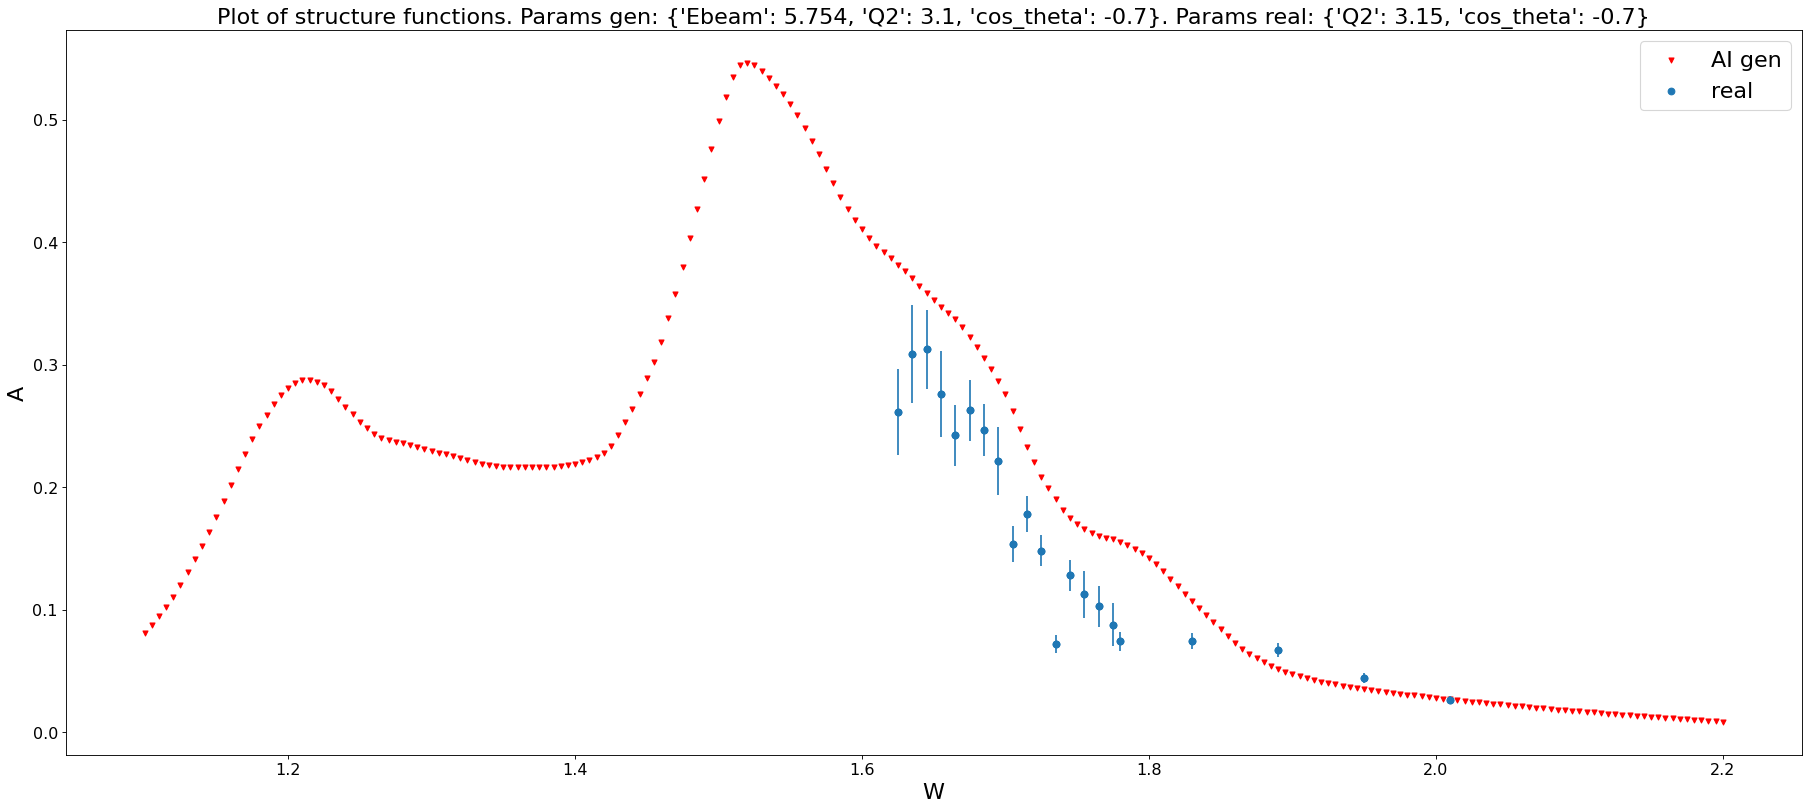

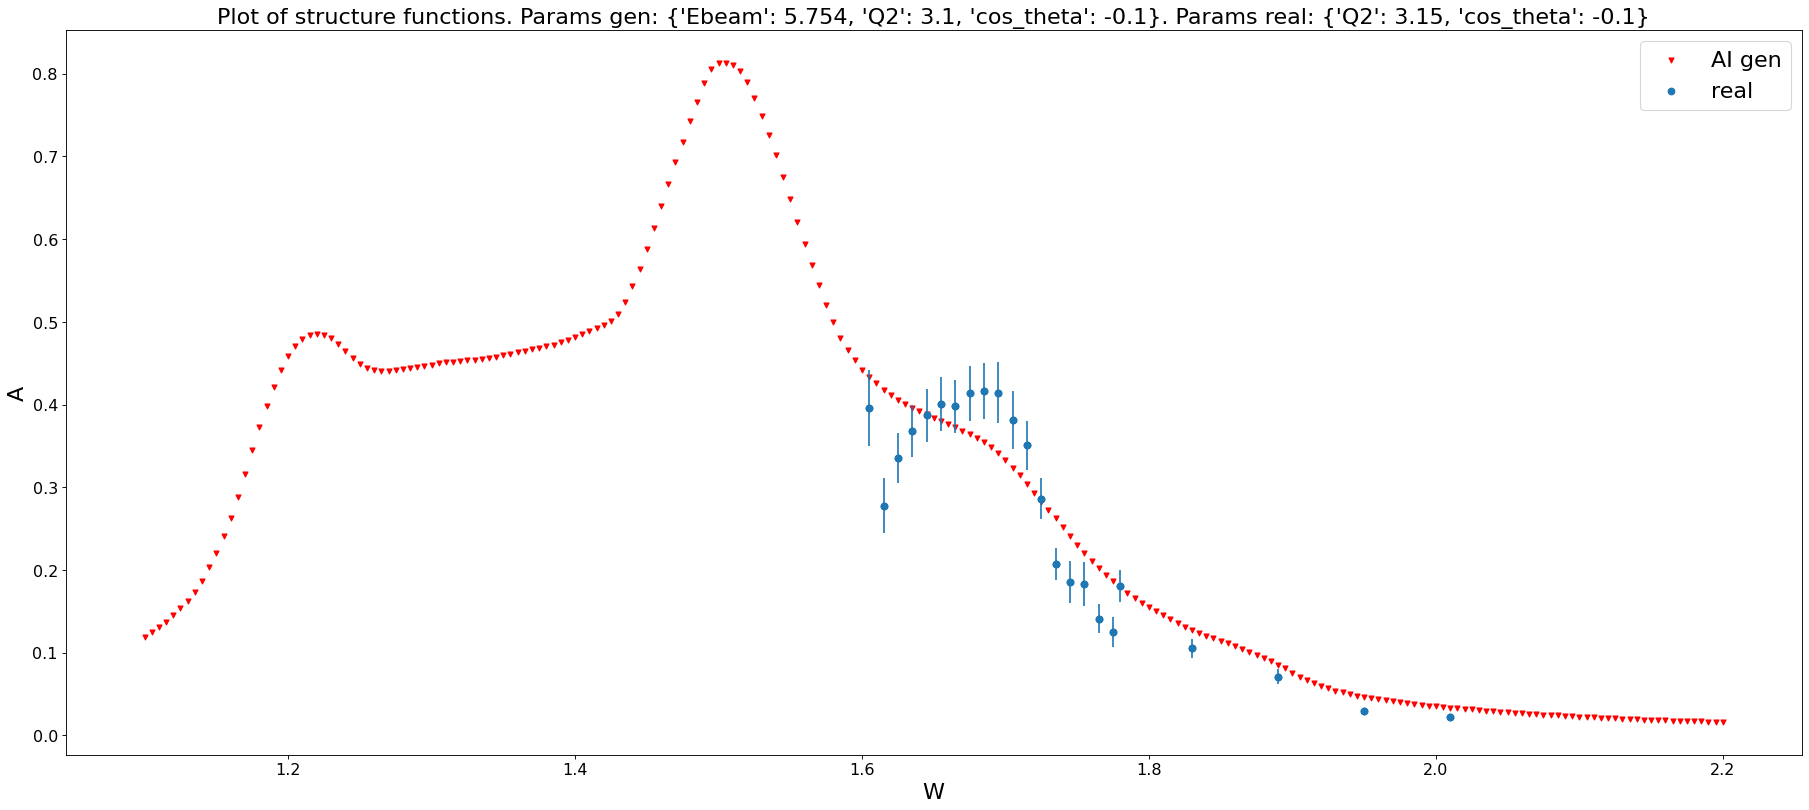

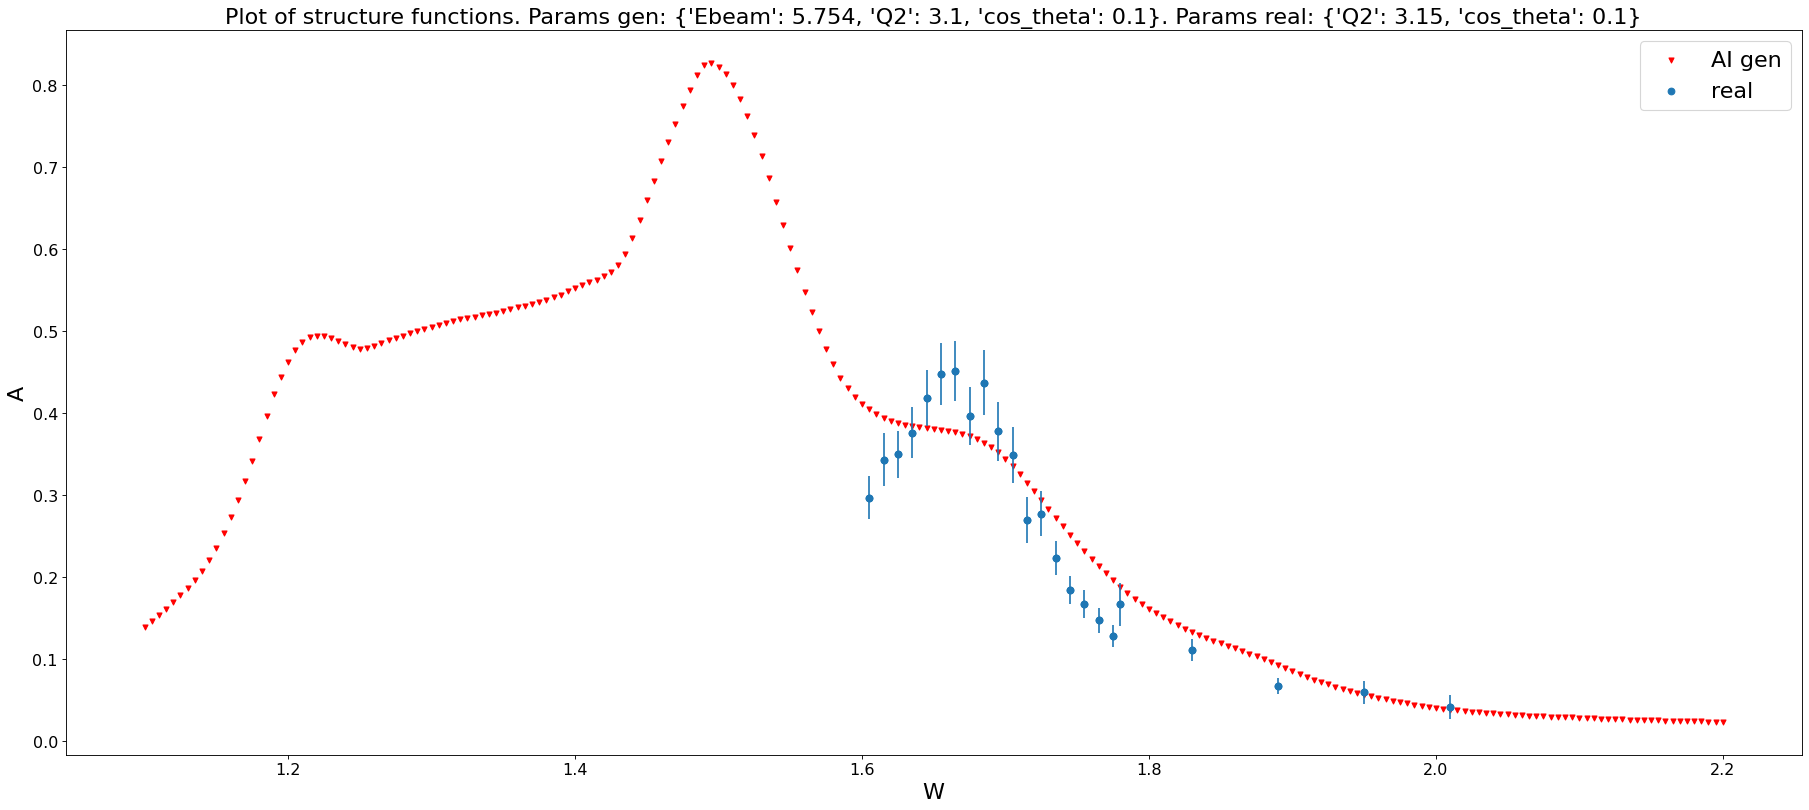

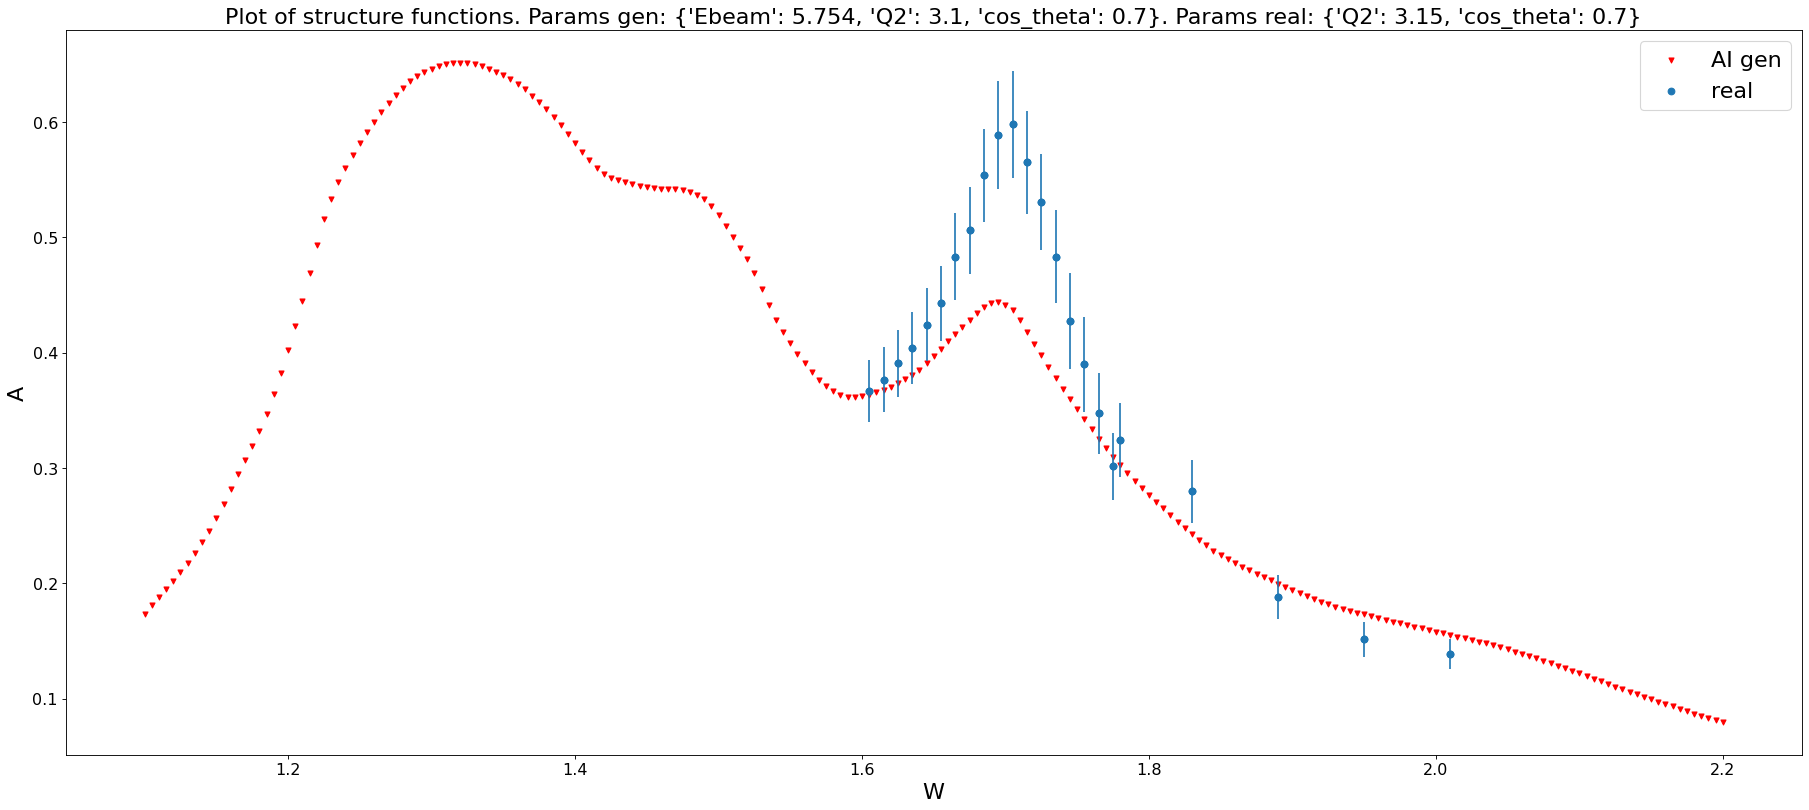

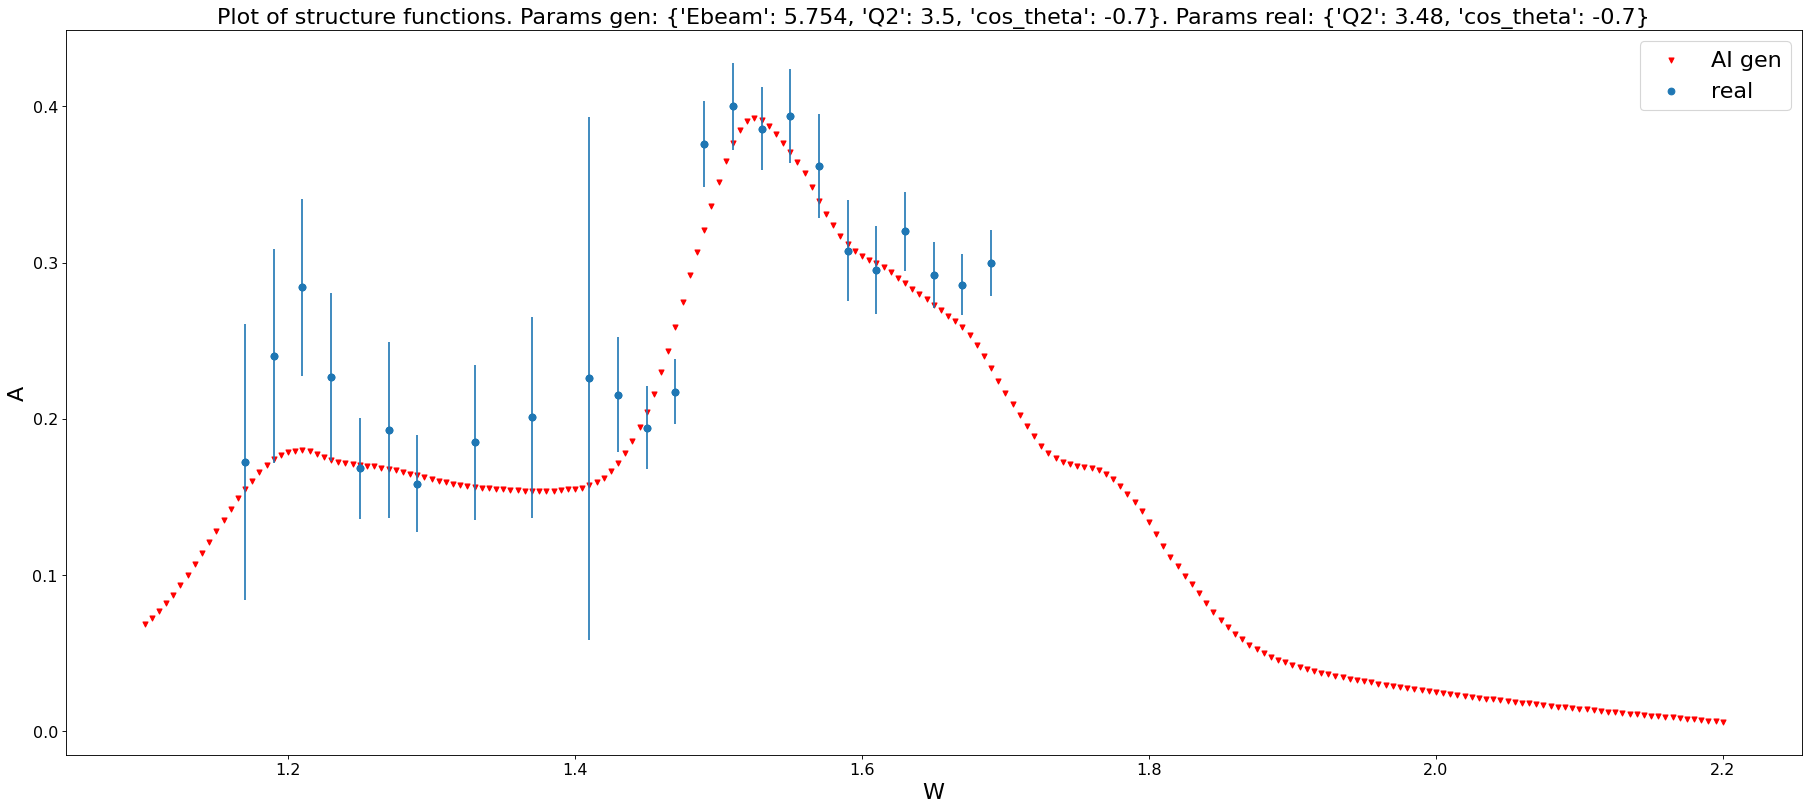

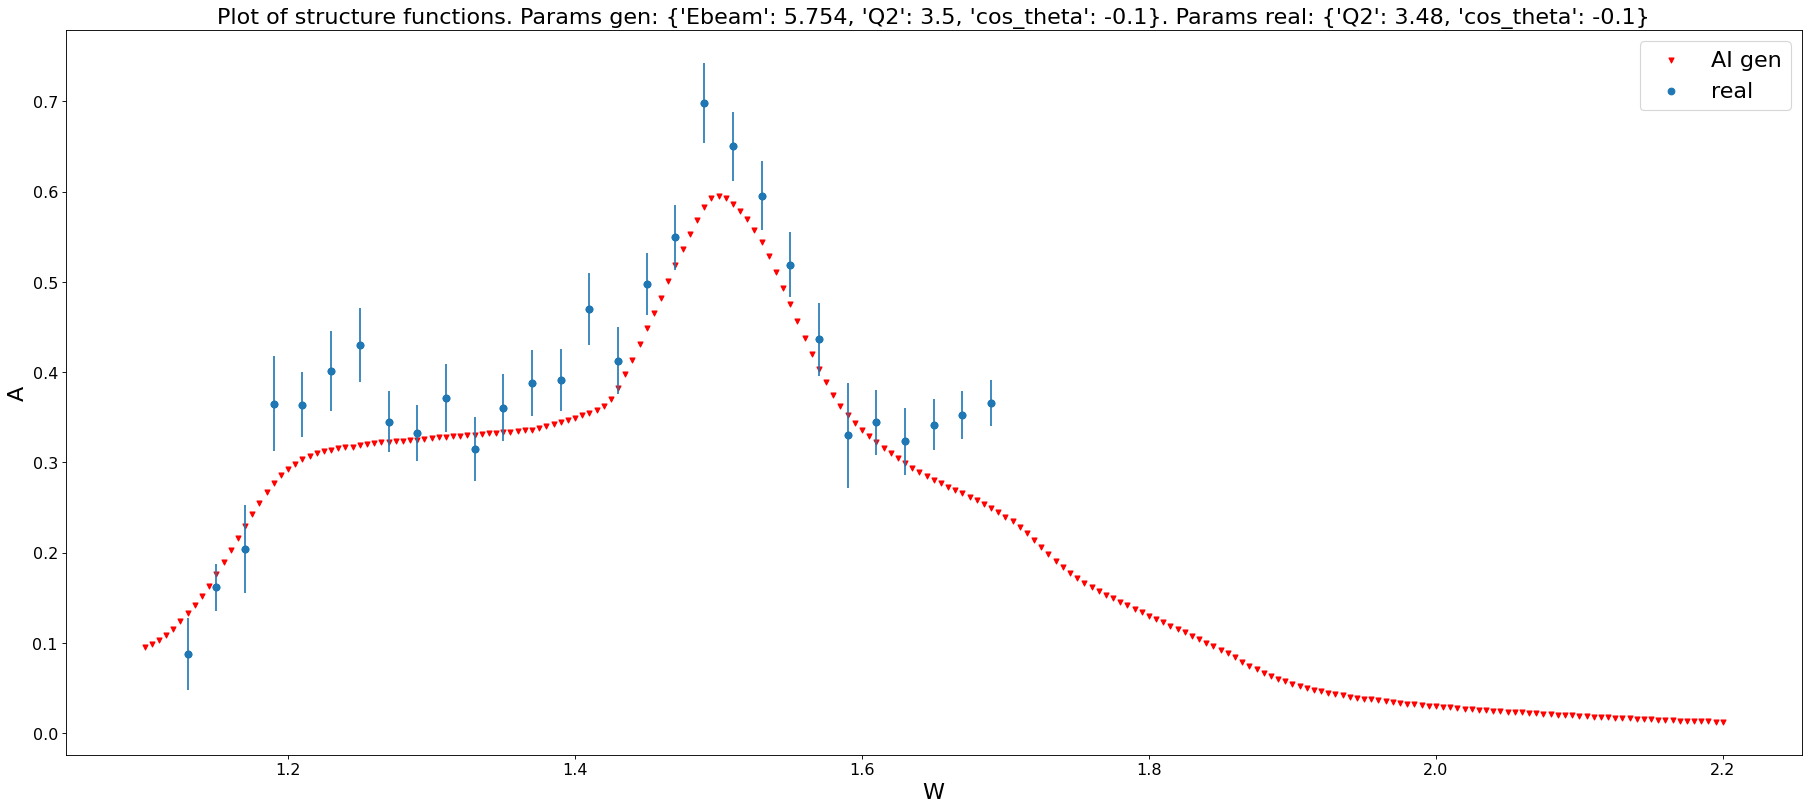

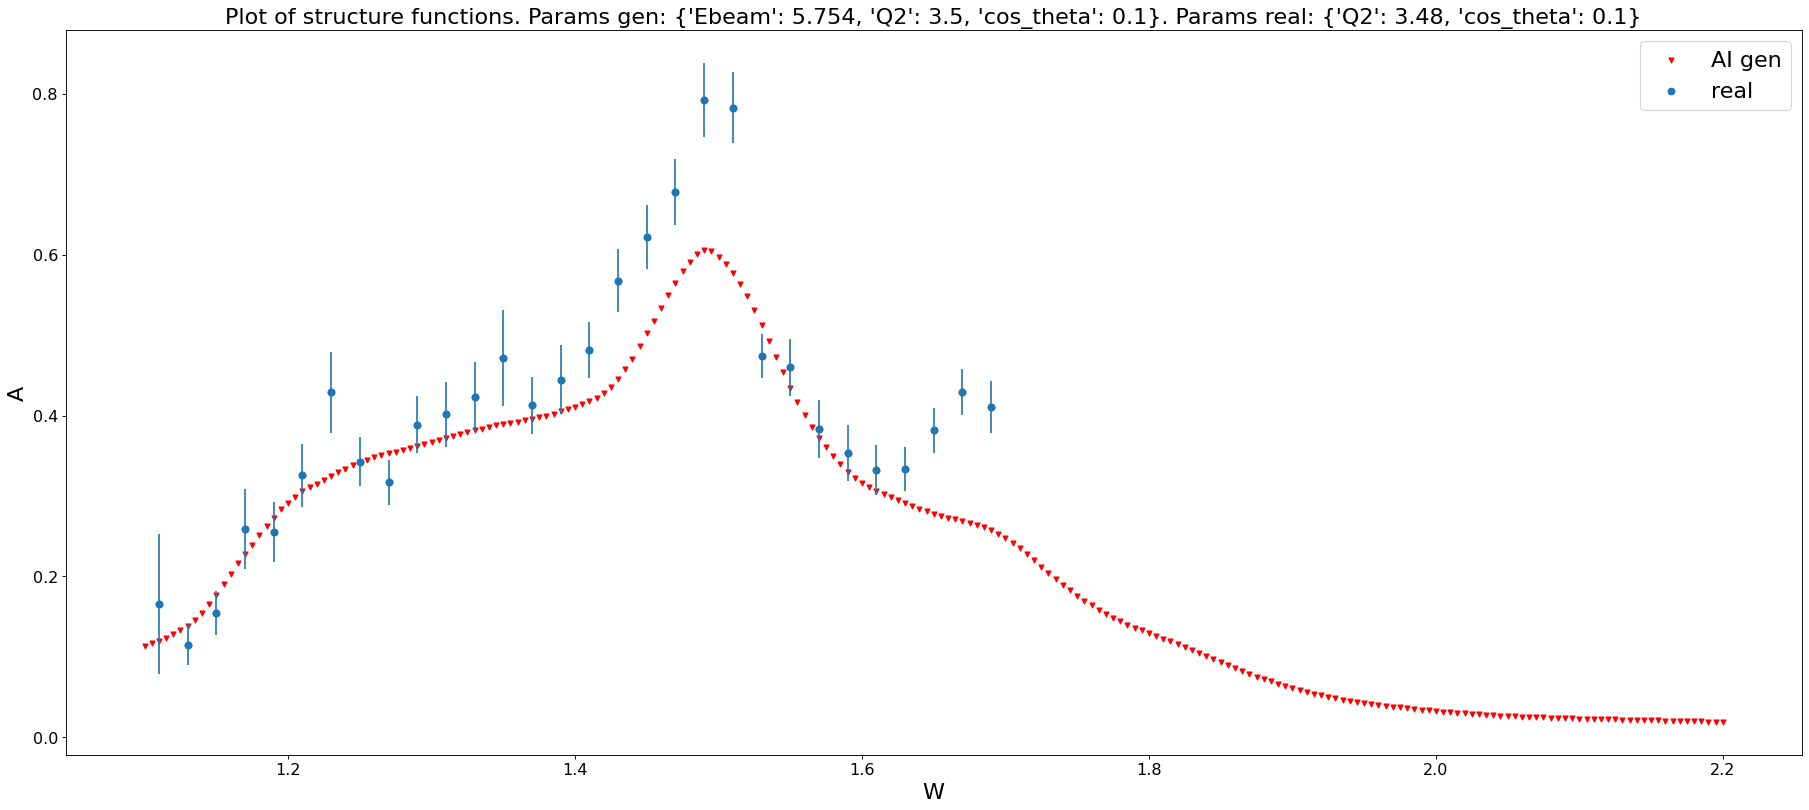

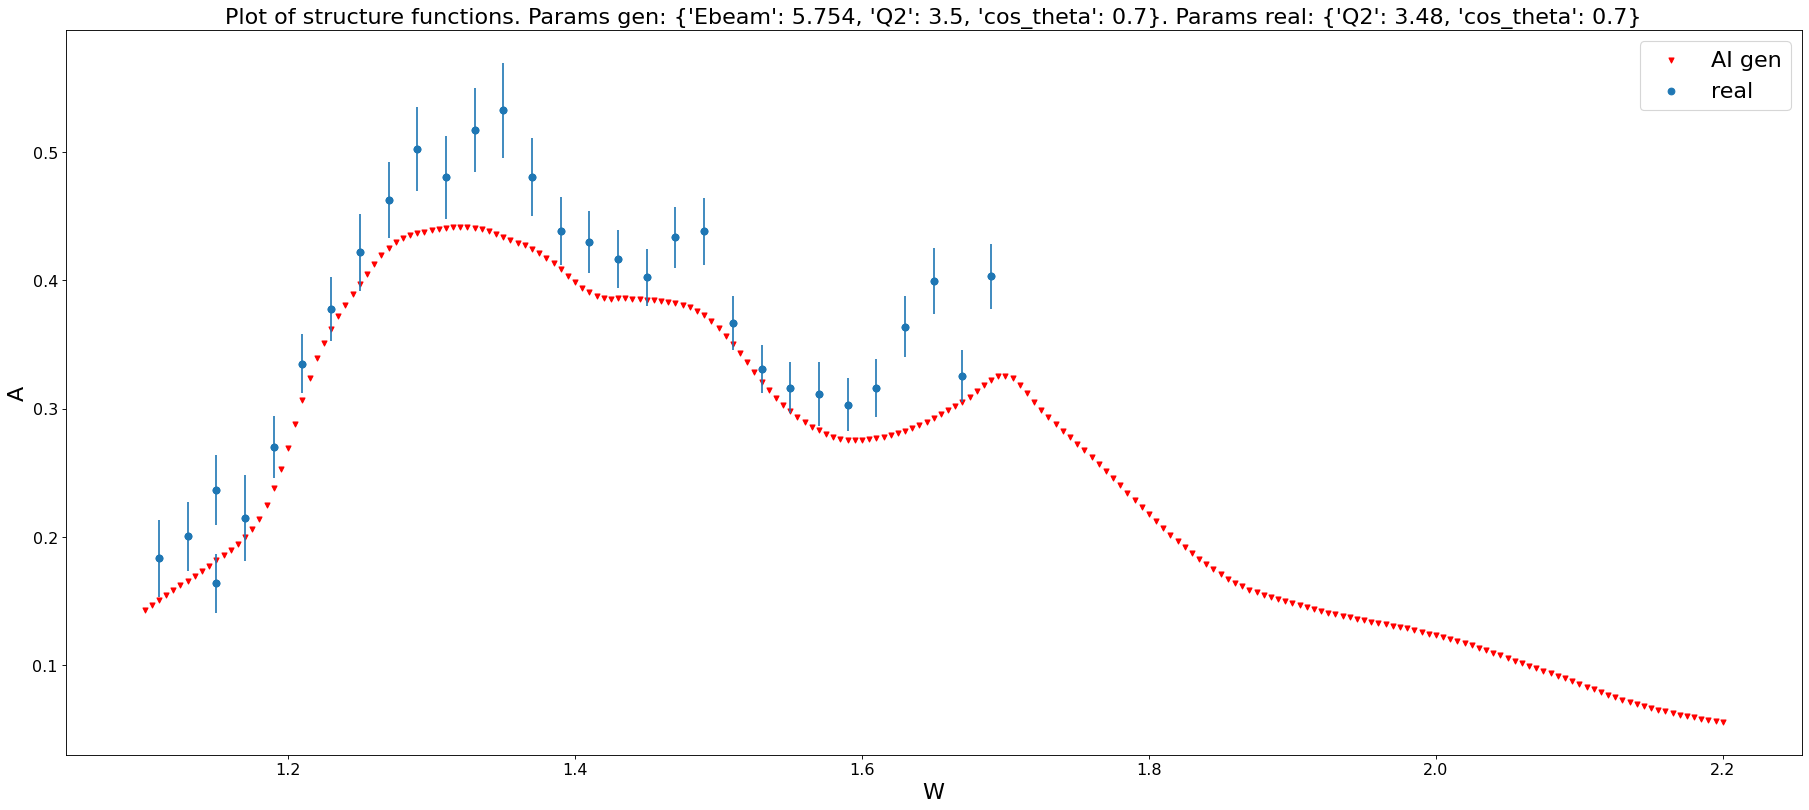

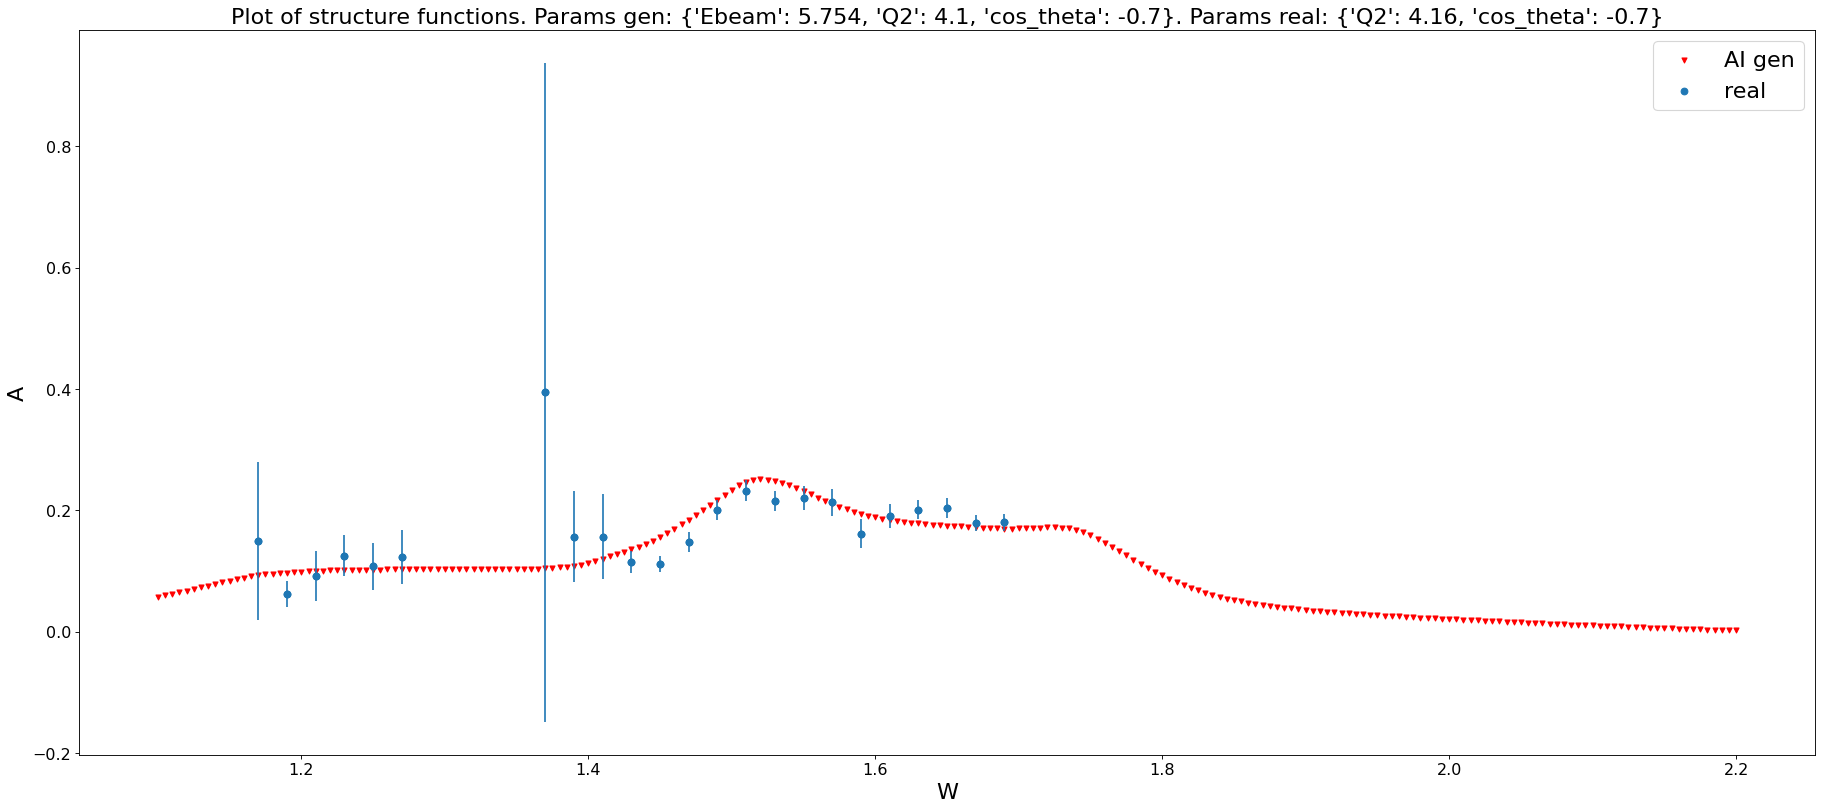

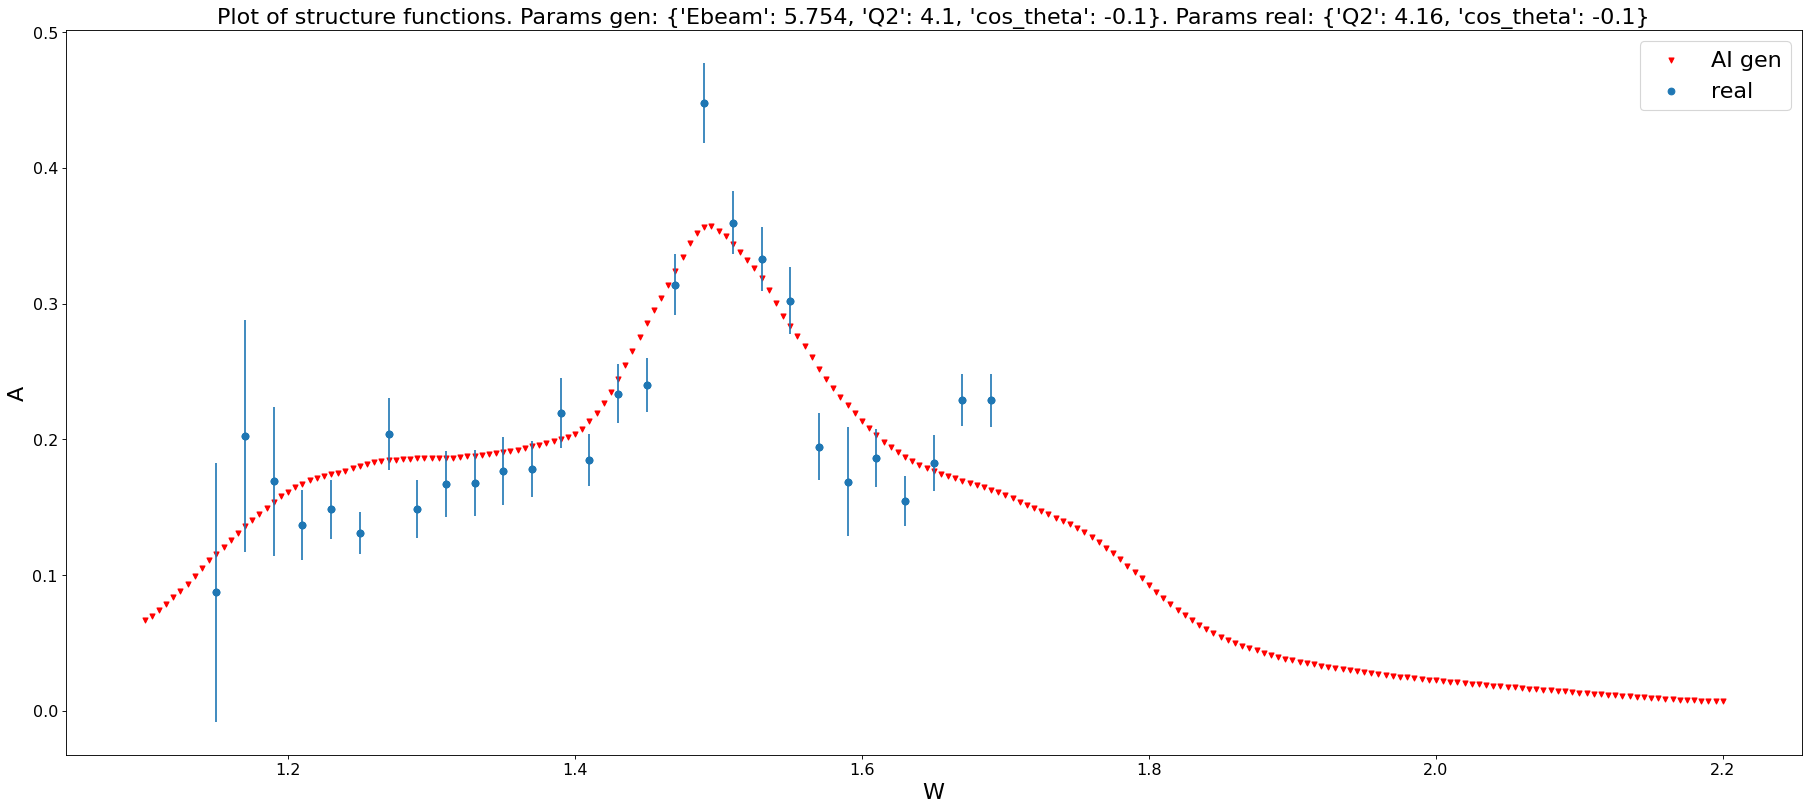

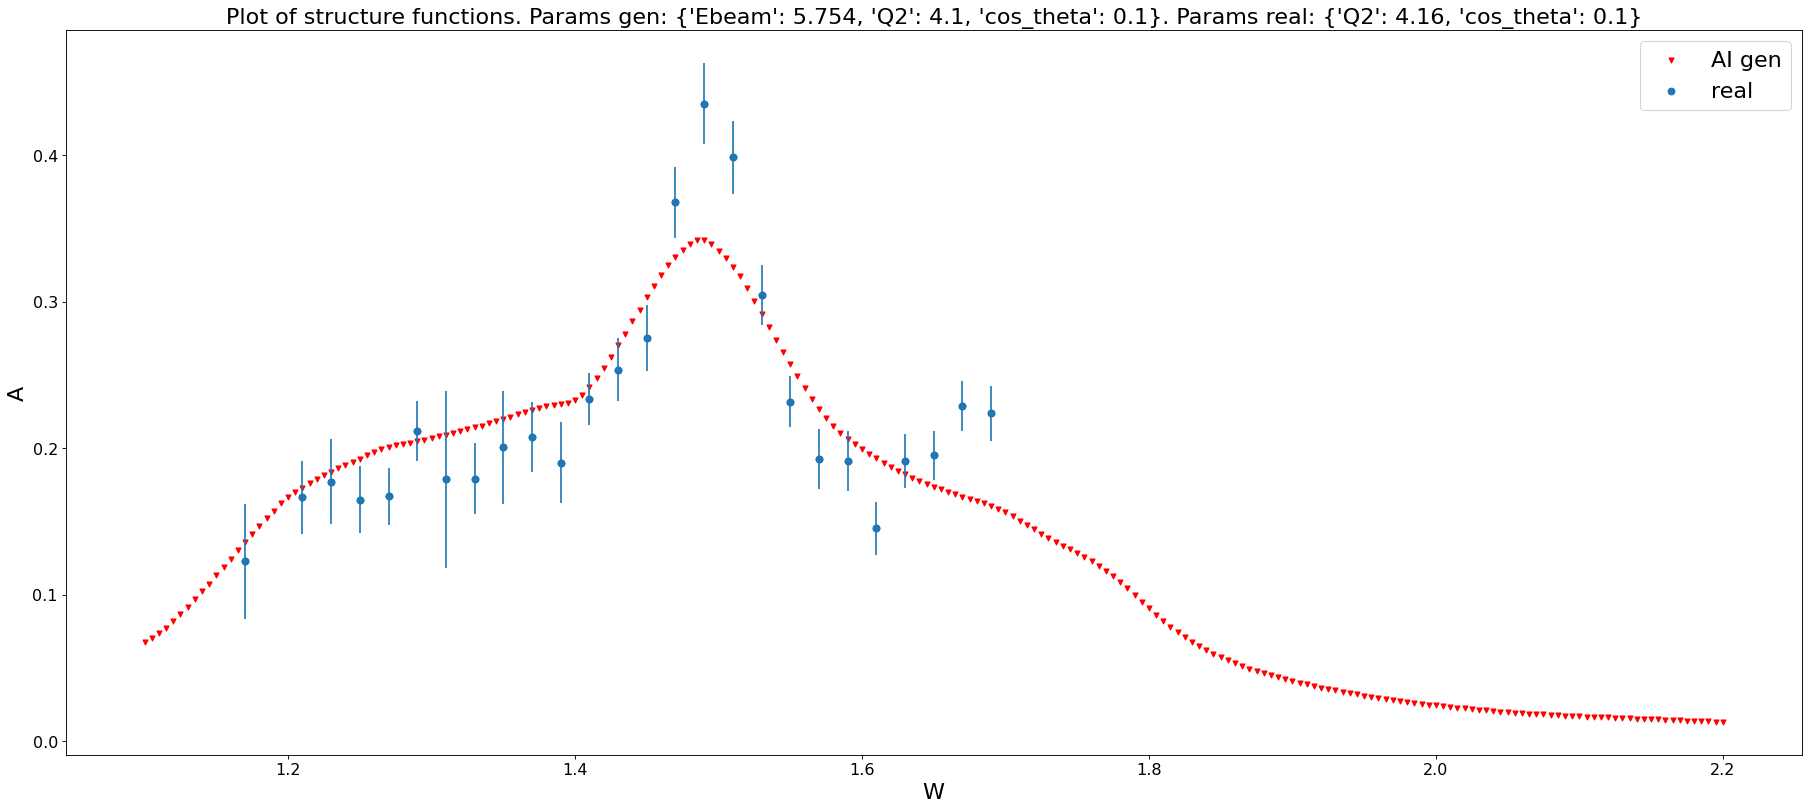

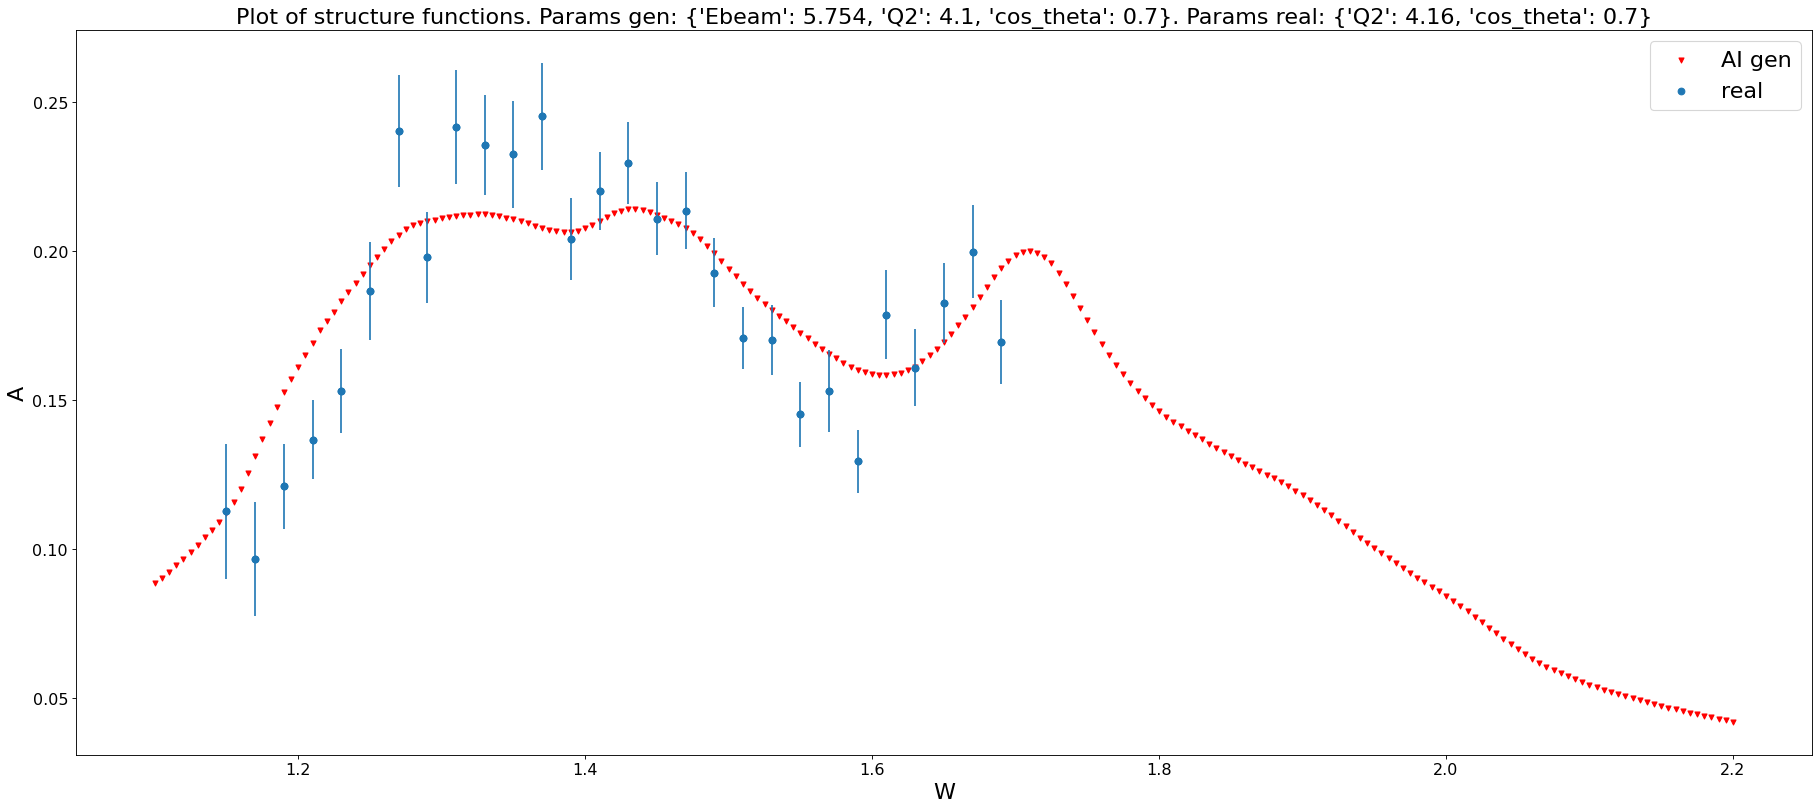

In [63]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (25, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

Ebeam = 5.754
Q2_gen = [1.7, 2.2, 2.4, 2.6, 2.9, 3.1, 3.5, 4.1]
Q2_real = [1.72, 2.2, 2.44, 2.6, 2.91, 3.15, 3.48, 4.16]

cos_theta_gen = cos_theta_real = [-0.7, -0.1, 0.1, 0.7]

for i in range(len(Q2_gen)):
    for j in range(len(cos_theta_gen)):
        params_gen = {'Ebeam' : Ebeam,
                      'Q2' : Q2_gen[i],
                      'cos_theta' : cos_theta_gen[j]}

        params_real = {'Q2' : Q2_real[i],
                       'cos_theta' : cos_theta_real[j]}
        try:
            plot_gen_real_almaz(params_gen, params_real)
        except:
            pass